# Predicción de la dirección del precio de Bitcoin

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from scipy import stats

# Machine Learning básico
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            classification_report, roc_curve, auc, balanced_accuracy_score)

# Modelos clásicos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Feature importance y análisis
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Gradient Boosting (condicional)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: XGBoost no disponible")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("Warning: LightGBM no disponible")

# Deep Learning (condicional)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    tf.random.set_seed(42)
    KERAS_AVAILABLE = True
except ImportError:
    KERAS_AVAILABLE = False
    print("Warning: TensorFlow no disponible")

# Optimización (condicional)
try:
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    OPTUNA_AVAILABLE = True
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Warning: Optuna no disponible")

# Configuración global
warnings.filterwarnings('ignore')
np.random.seed(42)

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.grid'] = True
sns.set_style("whitegrid")
sns.set_palette("viridis")

In [5]:
print("=" * 80)
print("# Bitcoin Price Direction Prediction")
print("=" * 80)

# Bitcoin Price Direction Prediction


In [6]:
file_path = 'btc_prediction_with_sentiment.csv'
try:
    # Try loading from CSV
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    print(f"Dataset loaded successfully from {file_path}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Dataset loaded successfully from btc_prediction_with_sentiment.csv


In [7]:
print("\n## 1.2 Dataset Overview")
print("-" * 50)

print(f"Dataset shape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Date range: {df.index.min()} to {df.index.max()}")


## 1.2 Dataset Overview
--------------------------------------------------
Dataset shape: 262 rows, 22 columns
Date range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00


In [8]:
missing_values = df.isna().sum()
if missing_values.sum() > 0:
    print("\nColumns with missing values:")
    print(missing_values[missing_values > 0])
else:
    print("\nNo missing values found in the dataset. ✓")


No missing values found in the dataset. ✓


In [9]:
print("\nFirst few rows of the dataset:")
print(df.head())


First few rows of the dataset:
            MACD_hist_change  high_low_range    ROC_1d    ROC_3d  \
date                                                               
2024-01-01         90.927731        0.044387  4.912017  1.667654   
2024-01-02        107.648532        0.038319  1.790094  5.466175   
2024-01-03        -72.222570        0.109449 -4.692812  1.778584   
2024-01-04         39.009712        0.047416  3.108058  0.028505   
2024-01-05         21.060548        0.035518 -0.039001 -1.768935   

            dist_from_10d_low  BTC_Nasdaq_corr_5d  BTC_vs_Nasdaq  \
date                                                               
2024-01-01           1.066224           -0.558016       0.057294   
2024-01-02           1.085310           -0.401979       0.026142   
2024-01-03           1.049852            0.002691      -0.035162   
2024-01-04           1.082482            0.524962       0.036694   
2024-01-05           1.082060            0.232729      -0.001339   

            BT

In [10]:
print("\nColumns in the dataset:")
print(df.columns.tolist())


Columns in the dataset:
['MACD_hist_change', 'high_low_range', 'ROC_1d', 'ROC_3d', 'dist_from_10d_low', 'BTC_Nasdaq_corr_5d', 'BTC_vs_Nasdaq', 'BTC_Nasdaq_beta_10d', 'Close_to_SMA10', 'BB_width', 'target_nextday', 'sent_q2_flag', 'sent_accel', 'sent_vol', 'sent_delta', 'sent_5d', 'sent_cross_up', 'sent_q5_flag', 'sent_q2_flag_x_Close_to_SMA10', 'sent_q2_flag_x_high_low_range', 'sent_cross_up_x_high_low_range', 'sent_neg_x_high_low_range']


In [11]:
print("\n## 1.3 Features and Target Separation")
print("-" * 50)


## 1.3 Features and Target Separation
--------------------------------------------------


In [12]:
target_col = 'target_nextday'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in the dataset")

In [13]:
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

In [14]:
# Identify technical and sentiment features based on naming conventions
technical_features = [col for col in X.columns if not col.startswith('sent_')]
sentiment_features = [col for col in X.columns if col.startswith('sent_')]

In [15]:
print(f"Total features: {len(X.columns)}")
print(f"Technical features: {len(technical_features)}")
print(f"Sentiment features: {len(sentiment_features)}")

Total features: 21
Technical features: 10
Sentiment features: 11


In [16]:
print("\nTechnical features:")
for i, feature in enumerate(technical_features):
    print(f"{i+1}. {feature}")

print("\nSentiment features:")
for i, feature in enumerate(sentiment_features):
    print(f"{i+1}. {feature}")


Technical features:
1. MACD_hist_change
2. high_low_range
3. ROC_1d
4. ROC_3d
5. dist_from_10d_low
6. BTC_Nasdaq_corr_5d
7. BTC_vs_Nasdaq
8. BTC_Nasdaq_beta_10d
9. Close_to_SMA10
10. BB_width

Sentiment features:
1. sent_q2_flag
2. sent_accel
3. sent_vol
4. sent_delta
5. sent_5d
6. sent_cross_up
7. sent_q5_flag
8. sent_q2_flag_x_Close_to_SMA10
9. sent_q2_flag_x_high_low_range
10. sent_cross_up_x_high_low_range
11. sent_neg_x_high_low_range



## 1.4 Target Variable Analysis
--------------------------------------------------
Target distribution:
Class 1 (Up): 131 samples (50.00%)
Class 0 (Down): 131 samples (50.00%)


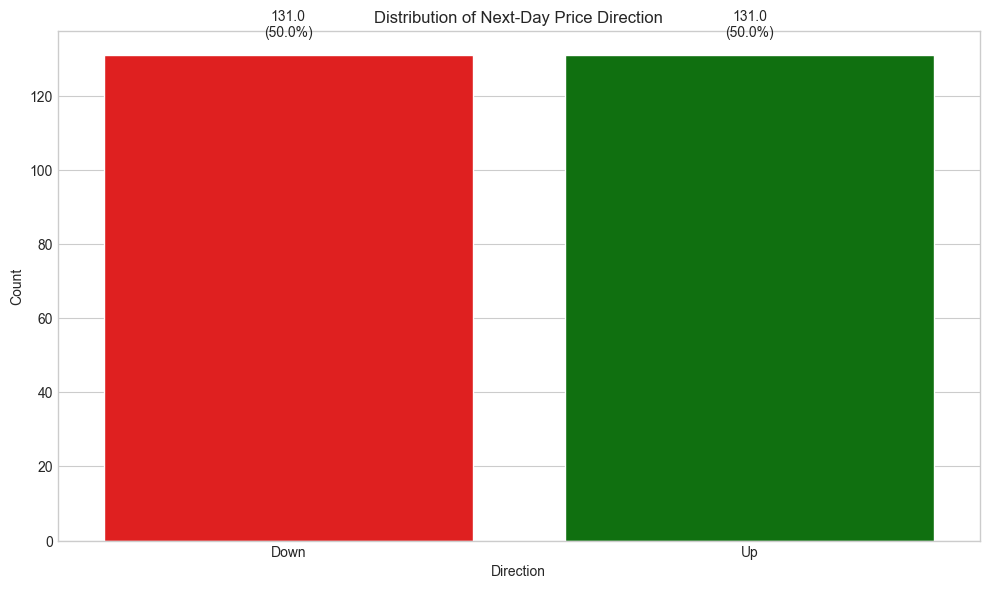

In [17]:
# 1.4 Target variable analysis
print("\n## 1.4 Target Variable Analysis")
print("-" * 50)

# Distribution of the target variable
target_counts = y.value_counts()
target_percentages = y.value_counts(normalize=True) * 100

print("Target distribution:")
for value, count in target_counts.items():
    percentage = target_percentages[value]
    print(f"Class {value} ({'Up' if value == 1 else 'Down'}): {count} samples ({percentage:.2f}%)")

# Plot target distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=y, palette=['red', 'green'])
ax.set_xticklabels(['Down', 'Up'])
ax.set_title('Distribution of Next-Day Price Direction')
ax.set_ylabel('Count')
ax.set_xlabel('Direction')

# Add count and percentage labels on bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 5,
            f'{height}\n({target_percentages.iloc[i]:.1f}%)',
            ha='center')

plt.tight_layout()
plt.show()


## 1.5 Time Series Considerations
--------------------------------------------------
Dataset is properly sorted chronologically. ✓


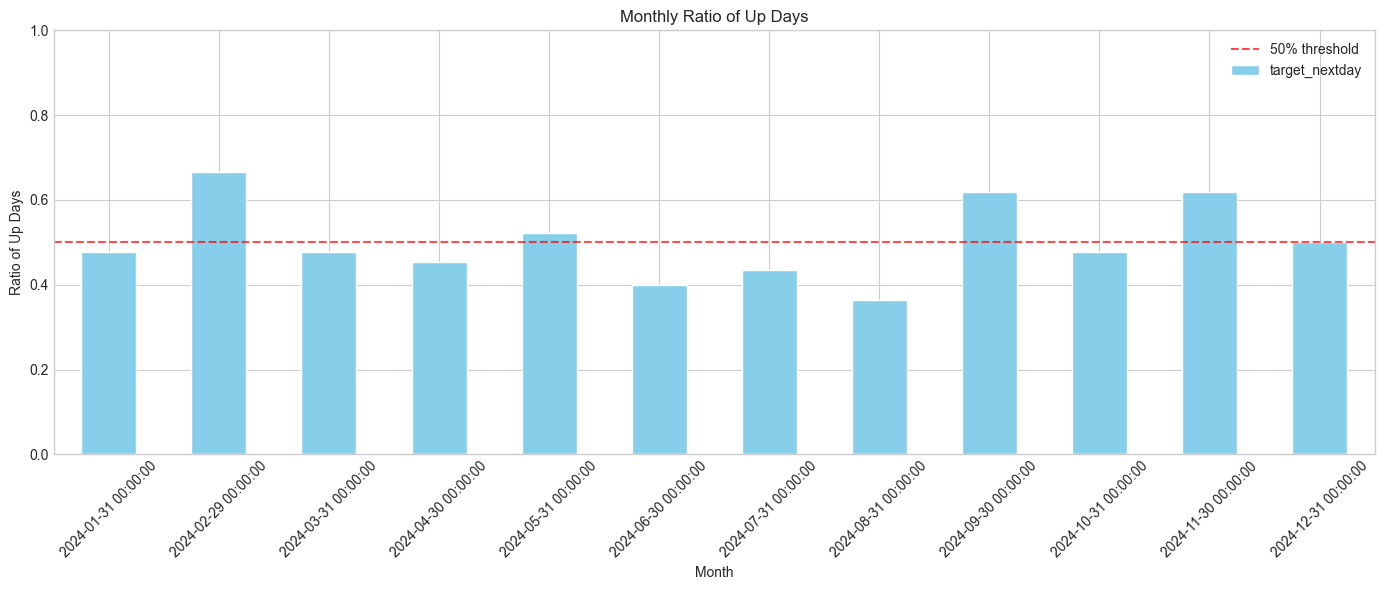


Monthly up-day ratios:
2024-01: 0.48 (47.8%)
2024-02: 0.67 (66.7%)
2024-03: 0.48 (47.6%)
2024-04: 0.45 (45.5%)
2024-05: 0.52 (52.2%)
2024-06: 0.40 (40.0%)
2024-07: 0.43 (43.5%)
2024-08: 0.36 (36.4%)
2024-09: 0.62 (61.9%)
2024-10: 0.48 (47.8%)
2024-11: 0.62 (61.9%)
2024-12: 0.50 (50.0%)

No regime features found in the dataset.


In [18]:
# 1.5 Time Series Considerations
print("\n## 1.5 Time Series Considerations")
print("-" * 50)

# Check if dataset is properly sorted by date
if not df.index.is_monotonic_increasing:
    print("WARNING: Dataset is not sorted chronologically. Sorting now...")
    df = df.sort_index()
    # Re-do the separation
    X = df.drop(columns=[target_col])
    y = df[target_col]
else:
    print("Dataset is properly sorted chronologically. ✓")

# Look at target variable distribution over time (monthly)
monthly_up_ratio = df.resample('M')[target_col].mean()

plt.figure(figsize=(14, 6))
monthly_up_ratio.plot(kind='bar', color='skyblue')
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, 
           label='50% threshold')
plt.title('Monthly Ratio of Up Days')
plt.ylabel('Ratio of Up Days')
plt.xlabel('Month')
plt.ylim(0, 1)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nMonthly up-day ratios:")
for date, ratio in monthly_up_ratio.items():
    print(f"{date.strftime('%Y-%m')}: {ratio:.2f} ({ratio*100:.1f}%)")

# Check if there are any regime features in the dataset
regime_features = [col for col in X.columns if 'regime' in col.lower()]
if regime_features:
    print("\nRegime features found in dataset:", regime_features)
    
    # Analyze target by regime
    regime_col = regime_features[0]
    regime_up_ratio = df.groupby(regime_col)[target_col].mean()
    
    print("\nTarget distribution by regime:")
    for regime, ratio in regime_up_ratio.items():
        count = df[df[regime_col] == regime].shape[0]
        print(f"Regime '{regime}': {ratio:.4f} up ratio ({count} samples)")
        
    # Plot target by regime
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=df[regime_col], hue=df[target_col], 
                      palette=['red', 'green'])
    plt.title('Price Direction by Market Regime')
    plt.xlabel('Market Regime')
    plt.ylabel('Count')
    plt.legend(['Down', 'Up'])
    plt.tight_layout()
    plt.show()
else:
    print("\nNo regime features found in the dataset.")


## 1.6 Feature Correlation with Target
--------------------------------------------------

Top 10 features by correlation magnitude:
                               correlation  abs_correlation
sent_q2_flag                      0.172251         0.172251
sent_q2_flag_x_Close_to_SMA10     0.171661         0.171661
sent_q2_flag_x_high_low_range     0.146337         0.146337
MACD_hist_change                 -0.109564         0.109564
ROC_1d                           -0.101278         0.101278
BTC_vs_Nasdaq                    -0.100355         0.100355
ROC_3d                           -0.094189         0.094189
sent_q5_flag                      0.066510         0.066510
sent_neg_x_high_low_range         0.060379         0.060379
BTC_Nasdaq_beta_10d              -0.056561         0.056561


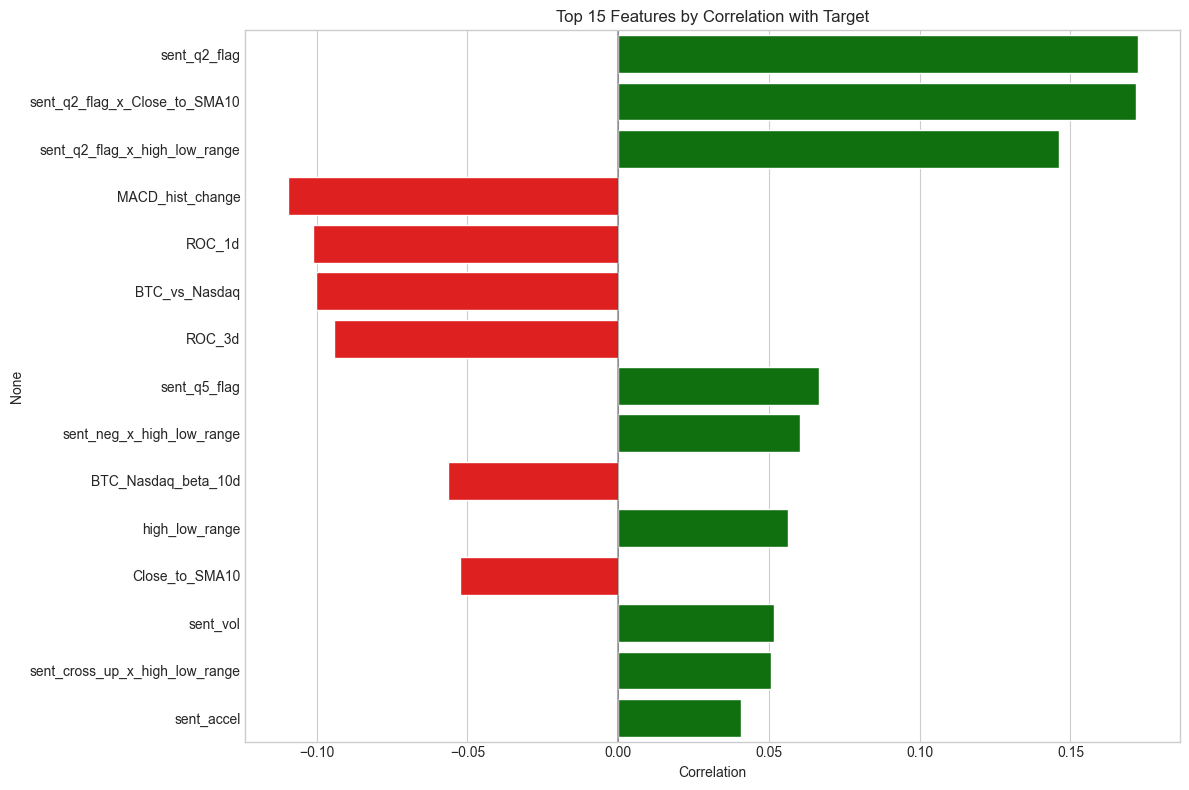


Of the top 15 correlated features:
- Technical features: 7
- Sentiment features: 8


In [19]:
# 1.6 Check feature correlations with target
print("\n## 1.6 Feature Correlation with Target")
print("-" * 50)

# Calculate correlations with target
correlations = pd.DataFrame(index=X.columns)
correlations['correlation'] = X.corrwith(y)
correlations['abs_correlation'] = correlations['correlation'].abs()
correlations = correlations.sort_values('abs_correlation', ascending=False)

# Display top correlations
print("\nTop 10 features by correlation magnitude:")
print(correlations.head(10))

# Plot top correlations
plt.figure(figsize=(12, 8))
top_n = 15  # Show top 15 features
top_features = correlations.head(top_n).index
top_corrs = correlations.loc[top_features, 'correlation']

# Create bar colors based on correlation sign
colors = ['green' if c > 0 else 'red' for c in top_corrs]

# Plot
sns.barplot(x=top_corrs.values, y=top_features, palette=colors)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title(f'Top {top_n} Features by Correlation with Target')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

# Count technical vs. sentiment features in top correlations
top_features_list = top_features.tolist()
n_technical = sum(1 for f in top_features_list if not f.startswith('sent_'))
n_sentiment = sum(1 for f in top_features_list if f.startswith('sent_'))

print(f"\nOf the top {top_n} correlated features:")
print(f"- Technical features: {n_technical}")
print(f"- Sentiment features: {n_sentiment}")


## 1.7 Feature Distributions
--------------------------------------------------


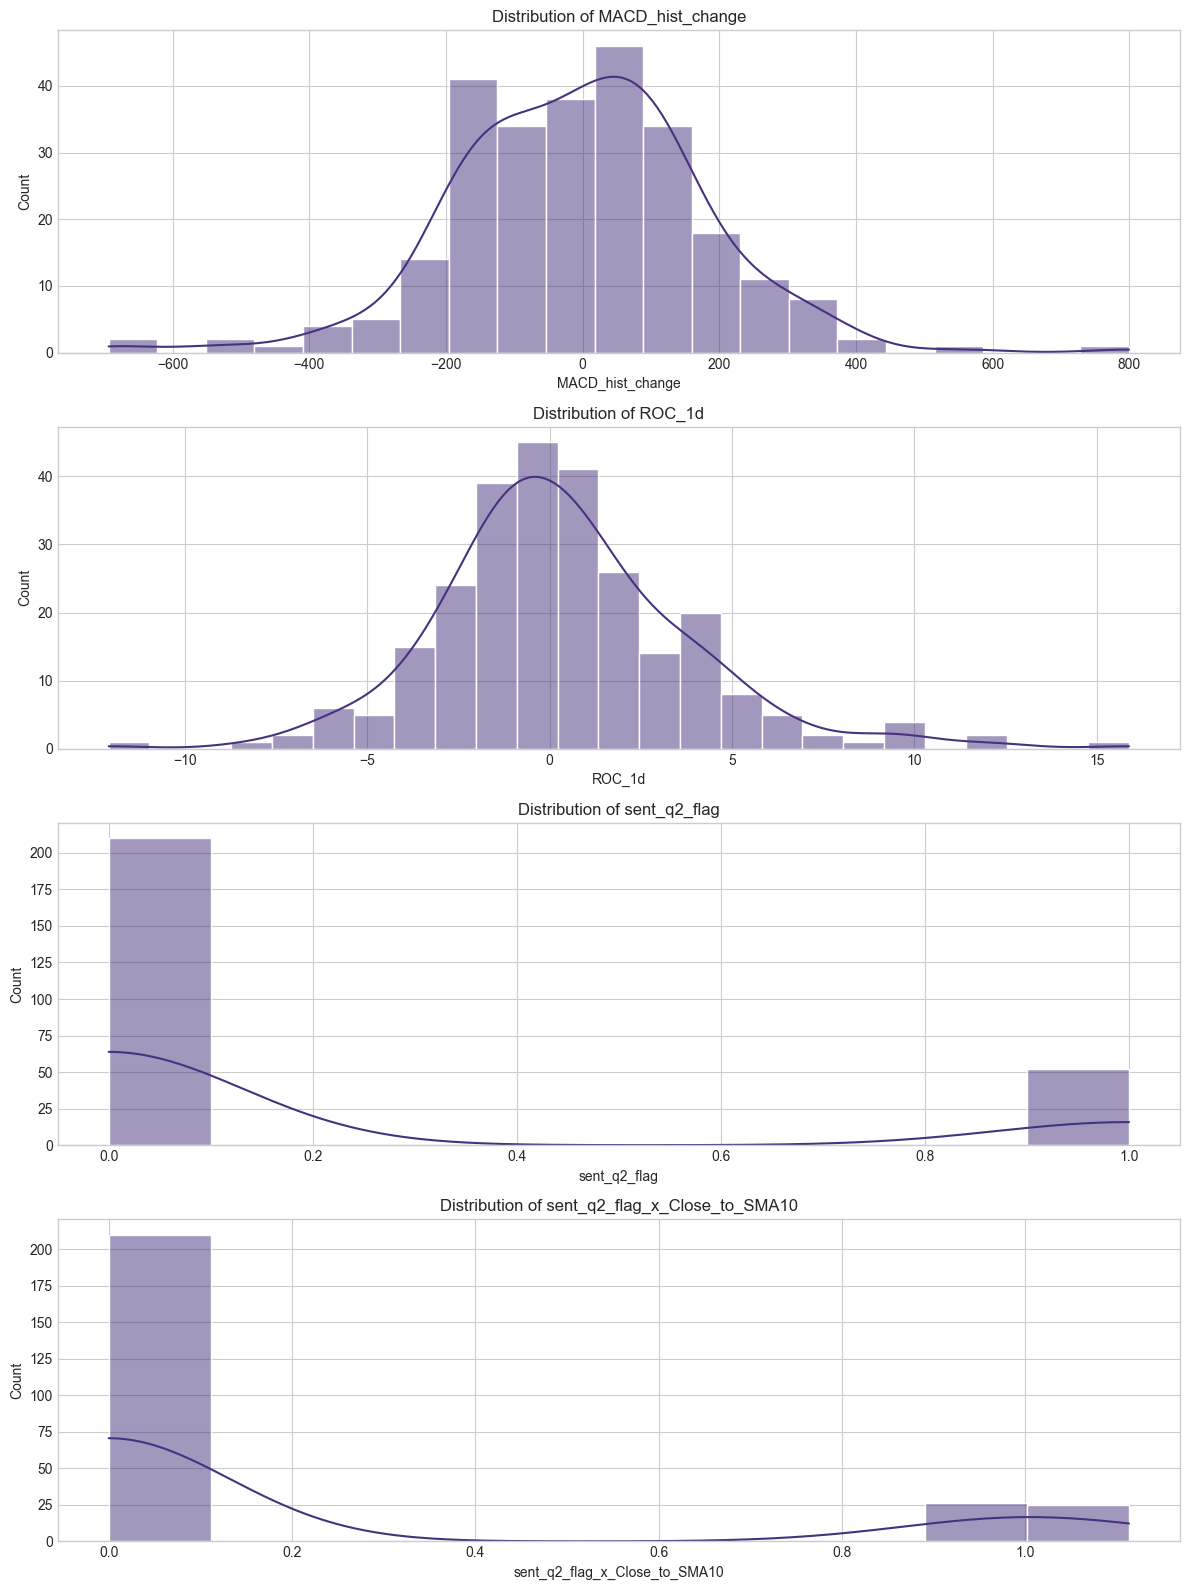

In [20]:
# 1.7 Feature distributions
print("\n## 1.7 Feature Distributions")
print("-" * 50)

# Select a few important features for visualization
if n_sentiment > 0:
    # Include some sentiment features
    top_sentiment = [f for f in top_features_list if f.startswith('sent_')][:2]
else:
    top_sentiment = []

if n_technical > 0:
    # Include some technical features
    top_technical = [f for f in top_features_list if not f.startswith('sent_')][:2]
else:
    top_technical = []

# Combine and ensure we have features to plot
features_to_plot = top_technical + top_sentiment
if not features_to_plot and len(X.columns) > 0:
    # If no top features, just take the first few
    features_to_plot = X.columns[:4].tolist()

# Plot histograms
if features_to_plot:
    fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(12, 4*len(features_to_plot)))
    if len(features_to_plot) == 1:
        axes = [axes]  # Make it iterable if only one subplot
        
    for i, feature in enumerate(features_to_plot):
        ax = axes[i]
        sns.histplot(X[feature], kde=True, ax=ax)
        ax.set_title(f'Distribution of {feature}')
        ax.set_xlabel(feature)
        
    plt.tight_layout()
    plt.show()

In [21]:
# 2.2 Time-based train-test split
print("\n## 2.2 Time-Based Train-Test Split")
print("-" * 50)

# Define train-test split ratio (80% train, 20% test)
train_size = 0.8
split_date = df.index[int(len(df) * train_size)]

print(f"Training data: from {df.index.min()} to {split_date}")
print(f"Testing data: from {split_date} to {df.index.max()}")


## 2.2 Time-Based Train-Test Split
--------------------------------------------------
Training data: from 2024-01-01 00:00:00 to 2024-10-18 00:00:00
Testing data: from 2024-10-18 00:00:00 to 2024-12-31 00:00:00


In [22]:
# Create train and test sets
X_train = X.loc[:split_date]
X_test = X.loc[split_date:]
y_train = y.loc[:split_date]
y_test = y.loc[split_date:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 210 samples
Testing set: 53 samples


In [23]:
# Check class distribution in train and test sets
train_class_dist = y_train.value_counts(normalize=True) * 100
test_class_dist = y_test.value_counts(normalize=True) * 100

print("\nClass distribution in training set:")
for value in sorted(train_class_dist.index):
    print(f"Class {value} ({'Up' if value == 1 else 'Down'}): {train_class_dist[value]:.2f}%")

print("\nClass distribution in testing set:")
for value in sorted(test_class_dist.index):
    print(f"Class {value} ({'Up' if value == 1 else 'Down'}): {test_class_dist[value]:.2f}%")


Class distribution in training set:
Class 0 (Down): 50.48%
Class 1 (Up): 49.52%

Class distribution in testing set:
Class 0 (Down): 49.06%
Class 1 (Up): 50.94%


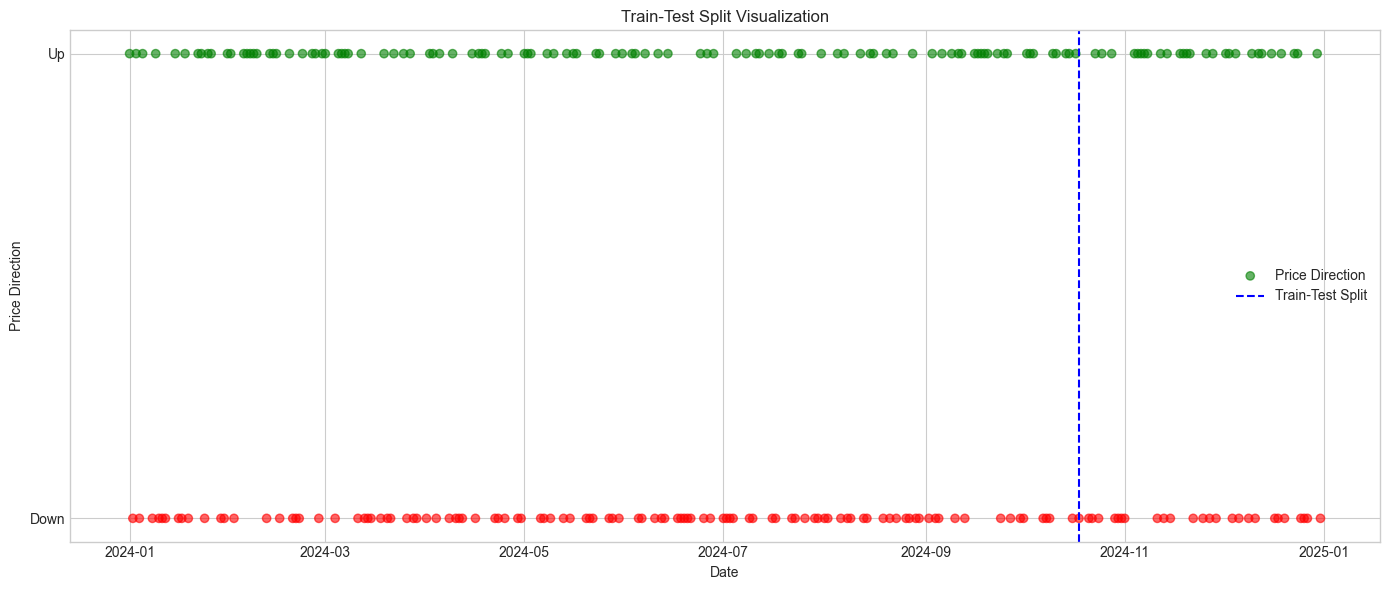

In [24]:
# Visualize train-test split on price direction
plt.figure(figsize=(14, 6))
plt.scatter(df.index, y, c=['red' if val == 0 else 'green' for val in y], 
           alpha=0.6, label='Price Direction')
plt.axvline(x=split_date, color='blue', linestyle='--', label='Train-Test Split')
plt.title('Train-Test Split Visualization')
plt.xlabel('Date')
plt.ylabel('Price Direction')
plt.yticks([0, 1], ['Down', 'Up'])
plt.legend()
plt.tight_layout()
plt.show()


## 2.3 Multicollinearity Analysis
--------------------------------------------------

Analyzing feature correlations...


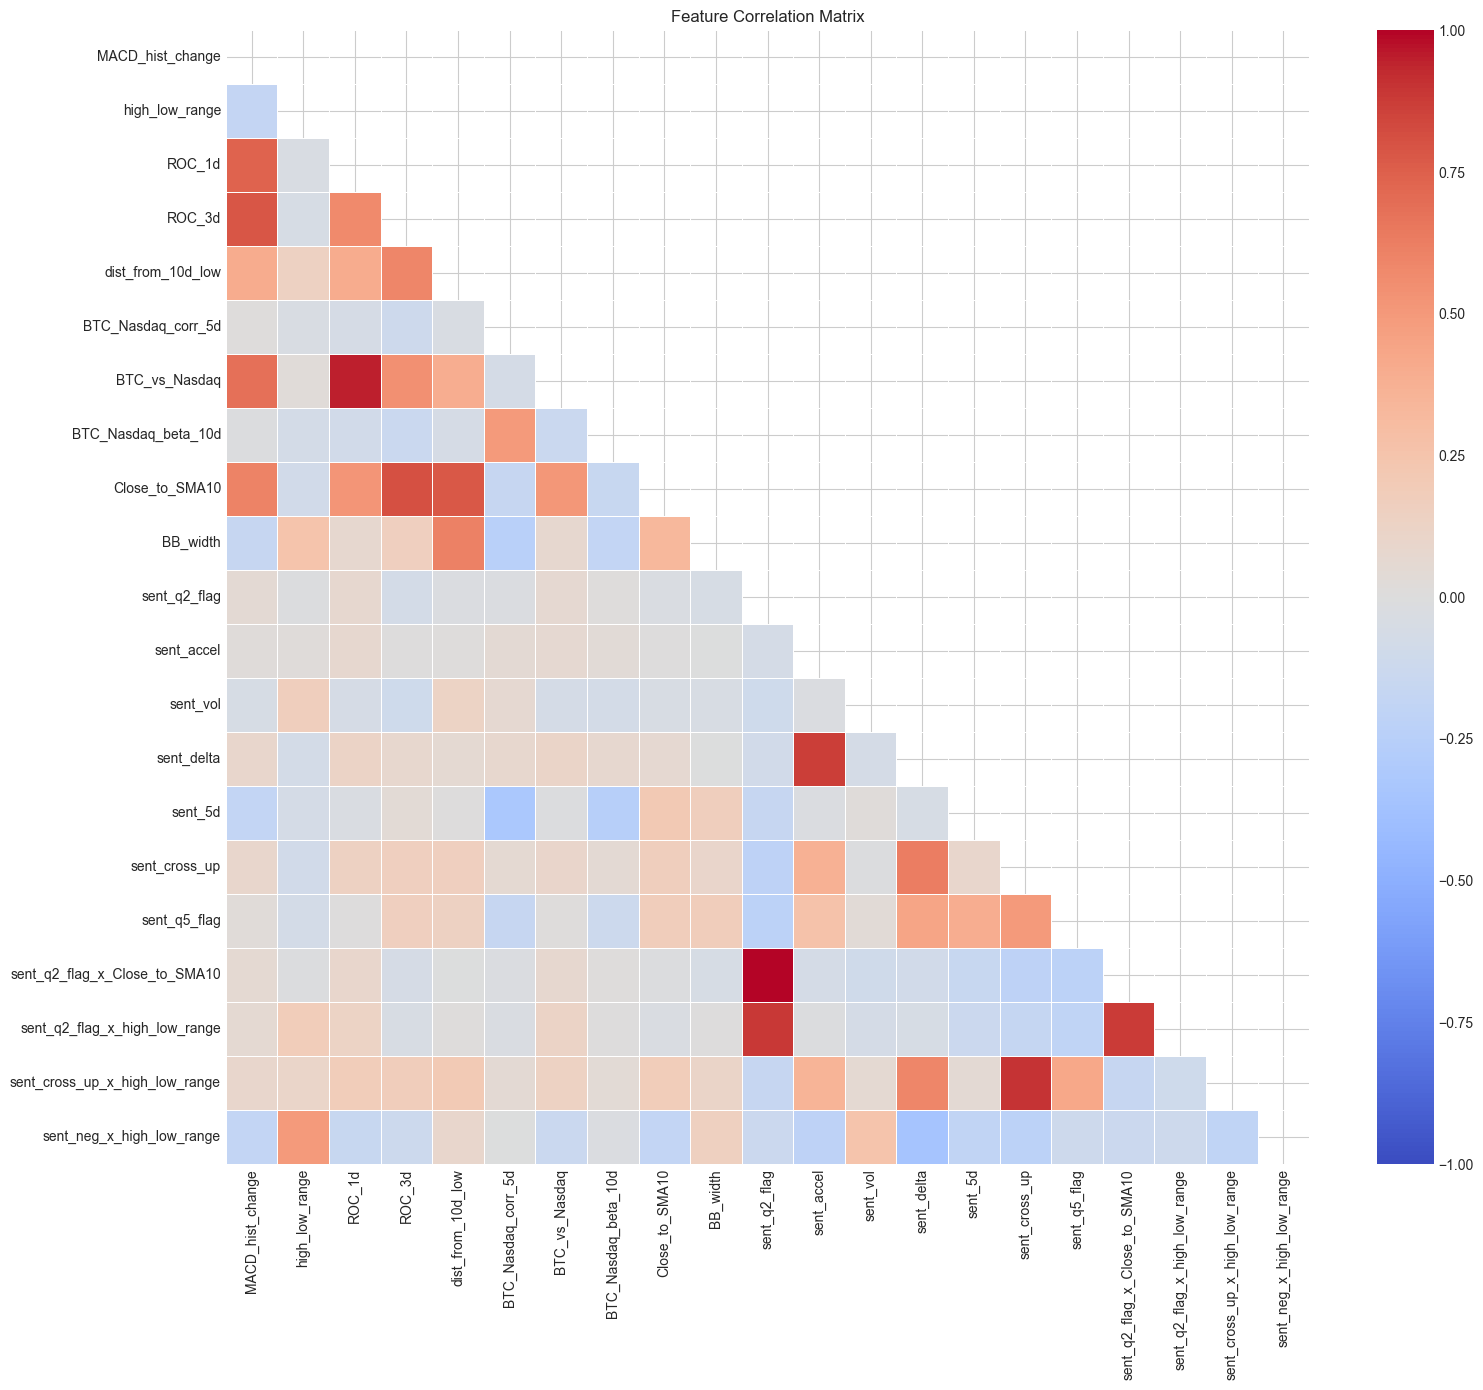

Highly correlated feature pairs (|r| > 0.7):
sent_q2_flag ~ sent_q2_flag_x_Close_to_SMA10: r = 0.9988
ROC_1d ~ BTC_vs_Nasdaq: r = 0.9480
sent_cross_up ~ sent_cross_up_x_high_low_range: r = 0.9043
sent_q2_flag ~ sent_q2_flag_x_high_low_range: r = 0.8834
sent_q2_flag_x_Close_to_SMA10 ~ sent_q2_flag_x_high_low_range: r = 0.8818
sent_accel ~ sent_delta: r = 0.8724
ROC_3d ~ Close_to_SMA10: r = 0.8058
MACD_hist_change ~ ROC_3d: r = 0.7888
dist_from_10d_low ~ Close_to_SMA10: r = 0.7781
MACD_hist_change ~ ROC_1d: r = 0.7414

Computing Variance Inflation Factor (VIF) scores...

VIF Scores (values > 5 indicate potential multicollinearity):
                           Feature         VIF
10                    sent_q2_flag  507.124781
17   sent_q2_flag_x_Close_to_SMA10  500.086188
2                           ROC_1d   14.081854
13                      sent_delta   12.112226
6                    BTC_vs_Nasdaq   11.467965
15                   sent_cross_up    9.822697
19  sent_cross_up_x_high_low_rang

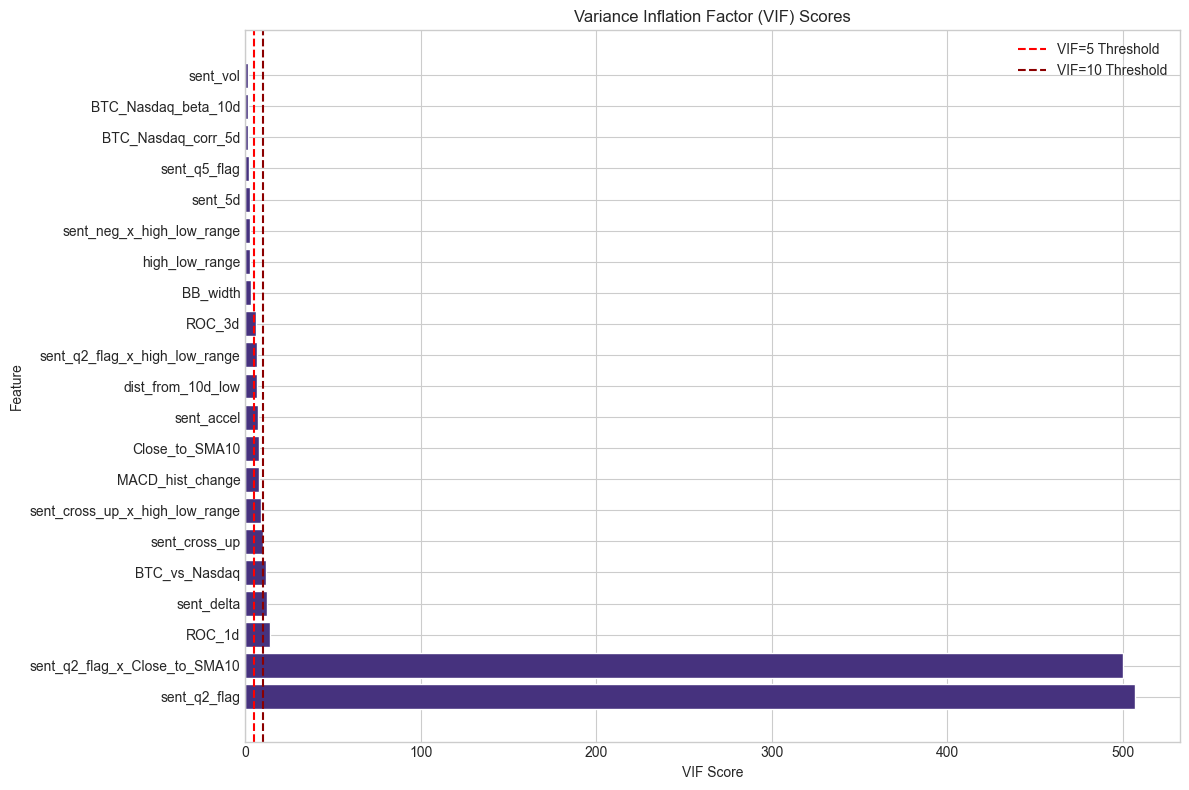

In [25]:
# 2.3 Multicollinearity Analysis
print("\n## 2.3 Multicollinearity Analysis")
print("-" * 50)

# Function to compute the correlation matrix and visualize it
def analyze_correlation_matrix(X, threshold=0.7):
    # Compute correlation matrix
    corr_matrix = X.corr()
    
    # Visualize correlation matrix
    plt.figure(figsize=(16, 14))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    heatmap = sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', 
                         vmin=-1, vmax=1, linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated feature pairs
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                                       corr_matrix.iloc[i, j]))
    
    # Sort by absolute correlation value
    high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    print(f"Highly correlated feature pairs (|r| > {threshold}):")
    if high_corr_pairs:
        for feat1, feat2, corr in high_corr_pairs:
            print(f"{feat1} ~ {feat2}: r = {corr:.4f}")
    else:
        print("No feature pairs exceed the correlation threshold.")
    
    return high_corr_pairs, corr_matrix

# Function to compute VIF scores
def compute_vif(X):
    # Create DataFrame for results
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    
    # Calculate VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Sort by VIF value
    vif_data = vif_data.sort_values("VIF", ascending=False)
    
    return vif_data

# Analyze correlation matrix for training data
print("\nAnalyzing feature correlations...")
high_corr_pairs, corr_matrix = analyze_correlation_matrix(X_train, threshold=0.7)

# Compute VIF scores for training data
print("\nComputing Variance Inflation Factor (VIF) scores...")
try:
    # Scale the data first for better VIF interpretation
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                                 columns=X_train.columns, index=X_train.index)
    
    vif_results = compute_vif(X_train_scaled)
    
    print("\nVIF Scores (values > 5 indicate potential multicollinearity):")
    print(vif_results)
    
    # Visualize VIF scores
    plt.figure(figsize=(12, 8))
    plt.barh(vif_results["Feature"], vif_results["VIF"])
    plt.axvline(x=5, color='red', linestyle='--', label='VIF=5 Threshold')
    plt.axvline(x=10, color='darkred', linestyle='--', label='VIF=10 Threshold')
    plt.title('Variance Inflation Factor (VIF) Scores')
    plt.xlabel('VIF Score')
    plt.ylabel('Feature')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error computing VIF scores: {e}")
    print("This can happen if there's perfect multicollinearity or other numerical issues.")

In [26]:
# 2.4 Addressing Multicollinearity
print("\n## 2.4 Addressing Multicollinearity")
print("-" * 50)

# Identify problematic features based on VIF and correlation analysis
if 'vif_results' in locals():
    problematic_vif = vif_results[vif_results["VIF"] > 10]["Feature"].tolist()
    print(f"Features with VIF > 10: {problematic_vif}")
else:
    problematic_vif = []
    print("VIF analysis not available.")

# Get unique problematic features from correlation analysis
problematic_corr = set()
for feat1, feat2, _ in high_corr_pairs:
    problematic_corr.add(feat1)
    problematic_corr.add(feat2)

print(f"Features in highly correlated pairs: {list(problematic_corr)}")

# Identify features that appear in both VIF and correlation lists
common_problematic = set(problematic_vif).intersection(problematic_corr)
print(f"Features problematic in both analyses: {list(common_problematic)}")

# Analyze which features are most important to keep
print("\nAnalyzing which features to keep based on correlation with target:")

# For each highly correlated pair, check correlation with target
if high_corr_pairs:
    target_corr = X_train.corrwith(y_train).abs()
    
    print("\nFor each highly correlated pair, comparing correlation with target:")
    for feat1, feat2, _ in high_corr_pairs:
        corr1 = target_corr[feat1]
        corr2 = target_corr[feat2]
        print(f"{feat1} (r={corr1:.4f}) vs {feat2} (r={corr2:.4f})")
        if corr1 > corr2:
            print(f"  Recommendation: Keep {feat1}, consider dropping {feat2}")
        else:
            print(f"  Recommendation: Keep {feat2}, consider dropping {feat1}")

# Create sets of features to keep and drop
print("\nRecommendations for feature selection:")

# Create a set to track features we'll keep
features_to_keep = set(X_train.columns)

# For each highly correlated pair, keep the one with higher correlation to target
if high_corr_pairs:
    features_to_drop = set()
    for feat1, feat2, _ in high_corr_pairs:
        # If both features are still in consideration
        if feat1 in features_to_keep and feat2 in features_to_keep:
            corr1 = abs(target_corr[feat1])
            corr2 = abs(target_corr[feat2])
            
            # Keep the feature with higher correlation to target
            if corr1 <= corr2:
                features_to_drop.add(feat1)
            else:
                features_to_drop.add(feat2)
    
    # Remove features to drop from features to keep
    features_to_keep = features_to_keep - features_to_drop
    
    print(f"Recommended features to drop: {list(features_to_drop)}")
    print(f"Number of features to keep: {len(features_to_keep)} (out of {X_train.shape[1]} total)")
    
    # Check how many technical vs sentiment features we're keeping
    kept_technical = [f for f in features_to_keep if not f.startswith('sent_')]
    kept_sentiment = [f for f in features_to_keep if f.startswith('sent_')]
    
    print(f"Technical features kept: {len(kept_technical)} out of {len(technical_features)}")
    print(f"Sentiment features kept: {len(kept_sentiment)} out of {len(sentiment_features)}")
else:
    print("No features need to be dropped based on correlation analysis.")

# Create reduced feature sets
X_train_reduced = X_train[list(features_to_keep)]
X_test_reduced = X_test[list(features_to_keep)]

print(f"\nReduced feature set size: {X_train_reduced.shape[1]} features")
print("Reduced feature set:")
for i, feature in enumerate(X_train_reduced.columns):
    print(f"{i+1}. {feature}")


## 2.4 Addressing Multicollinearity
--------------------------------------------------
Features with VIF > 10: ['sent_q2_flag', 'sent_q2_flag_x_Close_to_SMA10', 'ROC_1d', 'sent_delta', 'BTC_vs_Nasdaq']
Features in highly correlated pairs: ['ROC_3d', 'Close_to_SMA10', 'sent_cross_up_x_high_low_range', 'ROC_1d', 'BTC_vs_Nasdaq', 'MACD_hist_change', 'sent_accel', 'sent_q2_flag_x_high_low_range', 'sent_q2_flag_x_Close_to_SMA10', 'dist_from_10d_low', 'sent_q2_flag', 'sent_cross_up', 'sent_delta']
Features problematic in both analyses: ['ROC_1d', 'BTC_vs_Nasdaq', 'sent_q2_flag_x_Close_to_SMA10', 'sent_q2_flag', 'sent_delta']

Analyzing which features to keep based on correlation with target:

For each highly correlated pair, comparing correlation with target:
sent_q2_flag (r=0.1714) vs sent_q2_flag_x_Close_to_SMA10 (r=0.1715)
  Recommendation: Keep sent_q2_flag_x_Close_to_SMA10, consider dropping sent_q2_flag
ROC_1d (r=0.1086) vs BTC_vs_Nasdaq (r=0.0855)
  Recommendation: Keep ROC_1d, consi


## 2.5 Feature Scaling
--------------------------------------------------
Standardizing features...
Feature scaling complete.
Scaled training set shape: (210, 13)
Scaled testing set shape: (53, 13)


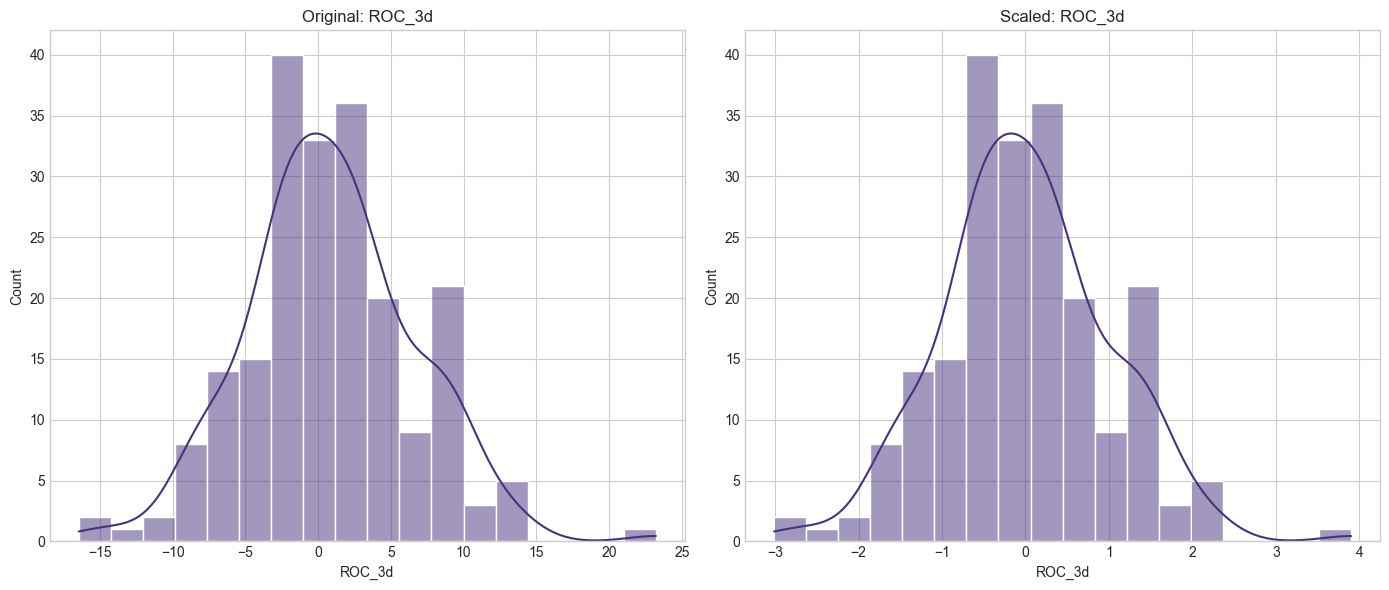

In [27]:
# 2.5 Feature Scaling
print("\n## 2.5 Feature Scaling")
print("-" * 50)

# Standardize features
print("Standardizing features...")
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_reduced), 
                             columns=X_train_reduced.columns, index=X_train_reduced.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_reduced), 
                            columns=X_test_reduced.columns, index=X_test_reduced.index)

print("Feature scaling complete.")
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled testing set shape: {X_test_scaled.shape}")

# Check the distribution of scaled features
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(X_train_reduced.iloc[:, 0], kde=True)
plt.title(f'Original: {X_train_reduced.columns[0]}')

plt.subplot(1, 2, 2)
sns.histplot(X_train_scaled.iloc[:, 0], kde=True)
plt.title(f'Scaled: {X_train_scaled.columns[0]}')

plt.tight_layout()
plt.show()

In [28]:
# 2.6 Prepare for Modeling
print("\n## 2.6 Prepare for Modeling")
print("-" * 50)

print("""
Data preparation is complete. We have:

1. **Created time-based train-test splits** that respect the temporal nature of the data
2. **Analyzed multicollinearity** among features using:
   - Correlation matrix analysis
   - Variance Inflation Factor (VIF) calculations
3. **Selected a reduced feature set** by addressing multicollinearity issues
4. **Scaled features** to ensure all variables are on the same scale

The data is now ready for modeling. In the next step, we will:
1. Train baseline models on the prepared data
2. Evaluate their performance using proper time series cross-validation
3. Analyze the results to establish performance benchmarks
""")

# Save prepared datasets for the next modeling step
try:
    # Save reduced and scaled datasets
    X_train_scaled.to_csv('X_train_scaled.csv')
    X_test_scaled.to_csv('X_test_scaled.csv')
    y_train.to_csv('y_train.csv')
    y_test.to_csv('y_test.csv')
    
    # Also save column names for reference
    pd.Series(X_train_scaled.columns).to_csv('feature_names.csv', index=False)
    
    print("\nPrepared datasets saved to CSV files for use in the next modeling step.")
except Exception as e:
    print(f"Error saving datasets: {e}")
    print("Will continue without saving files.")


## 2.6 Prepare for Modeling
--------------------------------------------------

Data preparation is complete. We have:

1. **Created time-based train-test splits** that respect the temporal nature of the data
2. **Analyzed multicollinearity** among features using:
   - Correlation matrix analysis
   - Variance Inflation Factor (VIF) calculations
3. **Selected a reduced feature set** by addressing multicollinearity issues
4. **Scaled features** to ensure all variables are on the same scale

The data is now ready for modeling. In the next step, we will:
1. Train baseline models on the prepared data
2. Evaluate their performance using proper time series cross-validation
3. Analyze the results to establish performance benchmarks


Prepared datasets saved to CSV files for use in the next modeling step.


# Final Multicollinearity Check for Bitcoin Price Direction Prediction
Loaded scaled datasets from CSV files

## 1. Correlation Matrix for Reduced Feature Set
--------------------------------------------------


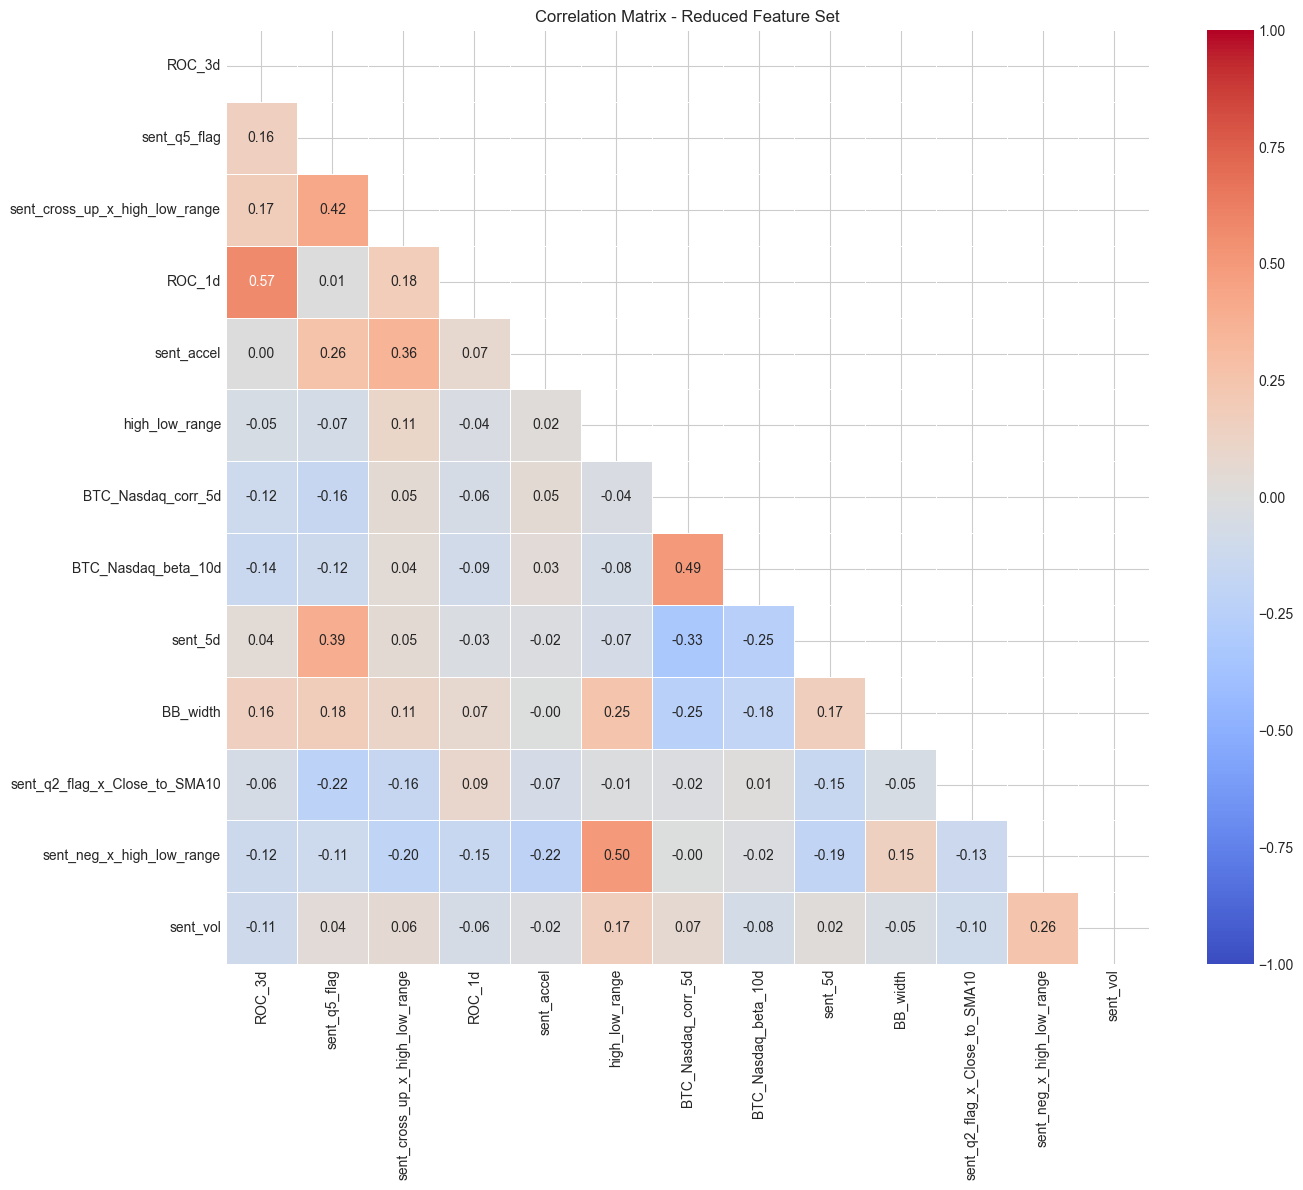

Remaining high correlations (|r| > 0.7):
No feature pairs exceed the correlation threshold. ✓

## 2. VIF Analysis for Reduced Feature Set
--------------------------------------------------
VIF Scores for Reduced Feature Set:
                           Feature       VIF
11       sent_neg_x_high_low_range  1.789367
1                     sent_q5_flag  1.650326
0                           ROC_3d  1.634559
3                           ROC_1d  1.594110
2   sent_cross_up_x_high_low_range  1.577340
5                   high_low_range  1.545878
6               BTC_Nasdaq_corr_5d  1.478399
8                          sent_5d  1.464550
7              BTC_Nasdaq_beta_10d  1.390953
4                       sent_accel  1.255166
9                         BB_width  1.223677
10   sent_q2_flag_x_Close_to_SMA10  1.152613
12                        sent_vol  1.145525

No features exceed the VIF threshold of 10. ✓


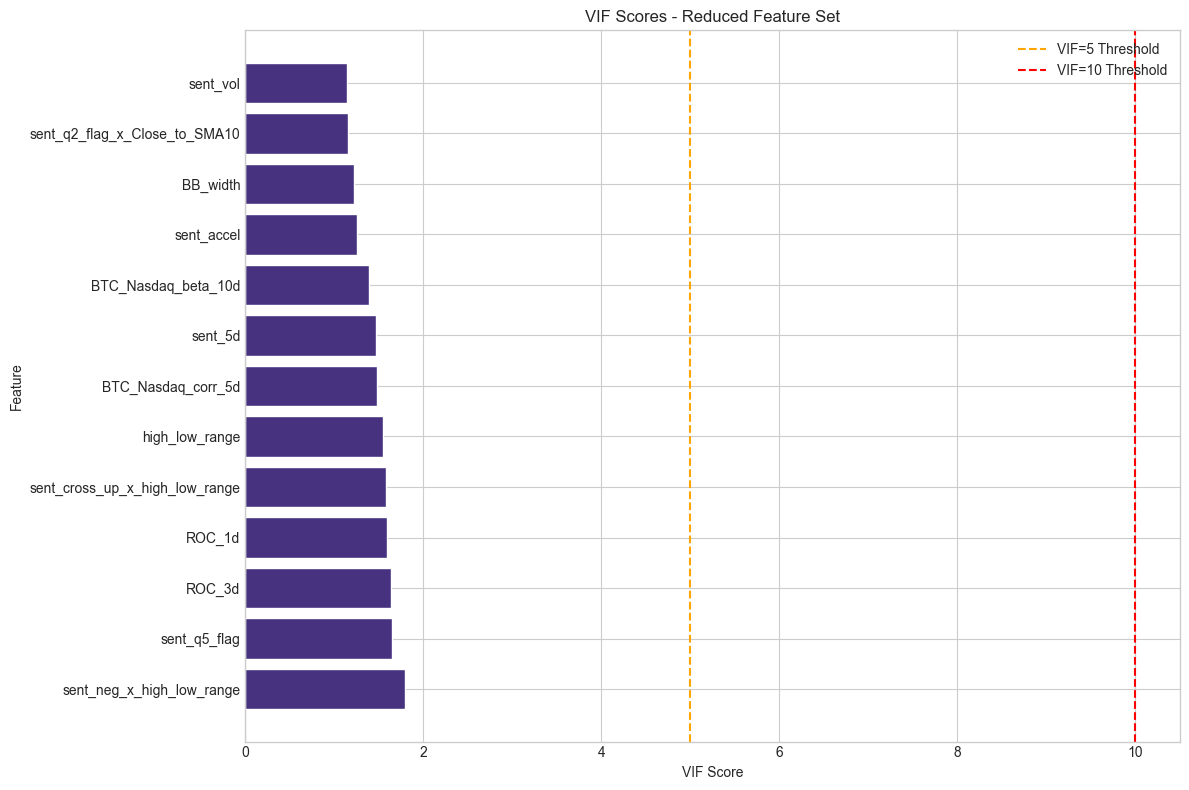


## 3. Final Assessment
--------------------------------------------------

✅ MULTICOLLINEARITY SUCCESSFULLY ADDRESSED

The reduced feature set shows no concerning levels of multicollinearity:
- No feature pairs with correlation above 0.7
- No features with VIF scores above 10

The dataset is now ready for modeling!
    

Ready to proceed with baseline modeling. ✓


In [29]:
print("# Final Multicollinearity Check for Bitcoin Price Direction Prediction")
print("=" * 80)

# Load the reduced and scaled datasets
try:
    # Try to load from CSV files
    X_train_scaled = pd.read_csv('X_train_scaled.csv', index_col=0)
    feature_names = pd.read_csv('feature_names.csv', header=None).iloc[:, 0].tolist()
    
    print("Loaded scaled datasets from CSV files")
except Exception as e:
    # If loading fails, try to use variables from memory
    if 'X_train_scaled' in locals() and 'X_train_reduced' in locals():
        print("Using datasets from current session")
    else:
        print(f"Error loading datasets: {e}")
        print("Please run the previous step first to create the required datasets")
        raise

# 1. Correlation Matrix for Reduced Feature Set
print("\n## 1. Correlation Matrix for Reduced Feature Set")
print("-" * 50)

# Compute and visualize correlation matrix
corr_matrix = X_train_scaled.corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
           vmin=-1, vmax=1, linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix - Reduced Feature Set')
plt.tight_layout()
plt.show()

# Check for remaining high correlations
high_corr_threshold = 0.7
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > high_corr_threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                                   corr_matrix.iloc[i, j]))

# Sort by absolute correlation value
high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print(f"Remaining high correlations (|r| > {high_corr_threshold}):")
if high_corr_pairs:
    for feat1, feat2, corr in high_corr_pairs:
        print(f"{feat1} ~ {feat2}: r = {corr:.4f}")
else:
    print("No feature pairs exceed the correlation threshold. ✓")

# 2. VIF Analysis for Reduced Feature Set
print("\n## 2. VIF Analysis for Reduced Feature Set")
print("-" * 50)

# Calculate VIF for each feature
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values("VIF", ascending=False)

try:
    # Calculate VIF scores
    vif_results = calculate_vif(X_train_scaled)
    
    print("VIF Scores for Reduced Feature Set:")
    print(vif_results)
    
    # Check for high VIF values
    high_vif_threshold = 10
    high_vif_features = vif_results[vif_results["VIF"] > high_vif_threshold]
    
    if len(high_vif_features) > 0:
        print(f"\nFeatures still showing high multicollinearity (VIF > {high_vif_threshold}):")
        print(high_vif_features)
    else:
        print(f"\nNo features exceed the VIF threshold of {high_vif_threshold}. ✓")
    
    # Visualize VIF scores
    plt.figure(figsize=(12, 8))
    plt.barh(vif_results["Feature"], vif_results["VIF"])
    plt.axvline(x=5, color='orange', linestyle='--', label='VIF=5 Threshold')
    plt.axvline(x=10, color='red', linestyle='--', label='VIF=10 Threshold')
    plt.title('VIF Scores - Reduced Feature Set')
    plt.xlabel('VIF Score')
    plt.ylabel('Feature')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error computing VIF scores: {e}")

# 3. Final Assessment
print("\n## 3. Final Assessment")
print("-" * 50)

# Decision based on both correlation and VIF analysis
if not high_corr_pairs and ('high_vif_features' in locals() and len(high_vif_features) == 0):
    print("""
✅ MULTICOLLINEARITY SUCCESSFULLY ADDRESSED

The reduced feature set shows no concerning levels of multicollinearity:
- No feature pairs with correlation above 0.7
- No features with VIF scores above 10

The dataset is now ready for modeling!
    """)
elif not high_corr_pairs:
    print("""
⚠️ PARTIAL IMPROVEMENT IN MULTICOLLINEARITY

While there are no highly correlated feature pairs, some features still show elevated VIF scores.
This mild multicollinearity should be manageable with regularization techniques in modeling.

Recommendation: Proceed with modeling using regularization (L1/L2) to handle remaining multicollinearity.
    """)
elif 'high_vif_features' in locals() and len(high_vif_features) == 0:
    print("""
⚠️ PARTIAL IMPROVEMENT IN MULTICOLLINEARITY

While VIF scores are under control, some feature pairs still show high correlations.
This may indicate remaining redundancy that could affect model interpretation but likely won't harm performance.

Recommendation: Proceed with modeling, but be cautious when interpreting feature importance.
    """)
else:
    print("""
⚠️ MULTICOLLINEARITY STILL PRESENT

Despite feature reduction, some multicollinearity issues remain in both correlation and VIF metrics.

Recommendation: Consider additional feature selection or use models that handle multicollinearity well 
(e.g., Lasso regression, elastic net, tree-based methods).
    """)

print("\nReady to proceed with baseline modeling. ✓")

## ML starts here!

In [30]:
print("\n## 3.1 Loading the Prepared Datasets")
print("-" * 50)

try:
    # Load from saved CSV files
    X_train_scaled = pd.read_csv('X_train_scaled.csv', index_col=0, parse_dates=True)
    X_test_scaled = pd.read_csv('X_test_scaled.csv', index_col=0, parse_dates=True)
    y_train = pd.read_csv('y_train.csv', index_col=0)
    y_test = pd.read_csv('y_test.csv', index_col=0)
    
    print("Datasets loaded successfully from CSV files")
    print(f"Training set: {X_train_scaled.shape[0]} samples, {X_train_scaled.shape[1]} features")
    print(f"Testing set: {X_test_scaled.shape[0]} samples")
except Exception as e:
    print(f"Error loading datasets: {e}")
    
# Show features being used
print("\nFeatures in the model:")
for i, col in enumerate(X_train_scaled.columns):
    print(f"{i+1}. {col}")

# Verify class distribution
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True) * 100)

print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True) * 100)


## 3.1 Loading the Prepared Datasets
--------------------------------------------------
Datasets loaded successfully from CSV files
Training set: 210 samples, 13 features
Testing set: 53 samples

Features in the model:
1. ROC_3d
2. sent_q5_flag
3. sent_cross_up_x_high_low_range
4. ROC_1d
5. sent_accel
6. high_low_range
7. BTC_Nasdaq_corr_5d
8. BTC_Nasdaq_beta_10d
9. sent_5d
10. BB_width
11. sent_q2_flag_x_Close_to_SMA10
12. sent_neg_x_high_low_range
13. sent_vol

Class distribution in training set:
target_nextday
0                 50.47619
1                 49.52381
Name: proportion, dtype: float64

Class distribution in test set:
target_nextday
1                 50.943396
0                 49.056604
Name: proportion, dtype: float64


In [31]:
# ===============================================================================
# CELDA 2: FUNCIONES DE UTILIDAD Y TESTS ESTADÍSTICOS
# ===============================================================================

def safe_float(value, default=0.0):
    """Convertir a float de forma segura"""
    try:
        if value is None or value == '' or pd.isna(value):
            return default
        return float(value)
    except (ValueError, TypeError):
        return default

def is_single_class_predictor(y_pred, threshold=0.95):
    """Verificar si un modelo predice principalmente una sola clase"""
    if len(y_pred) == 0:
        return True
    
    unique_vals, counts = np.unique(y_pred, return_counts=True)
    if len(unique_vals) == 1:
        return True
    
    max_ratio = max(counts) / len(y_pred)
    return max_ratio >= threshold

def delong_test(y_true, y_prob1, y_prob2, model1_name="Model 1", model2_name="Model 2"):
    """Test de DeLong para comparar AUCs de dos modelos"""
    try:
        auc1 = roc_auc_score(y_true, y_prob1)
        auc2 = roc_auc_score(y_true, y_prob2)
        
        n = len(y_true)
        var_auc1 = auc1 * (1 - auc1) / n
        var_auc2 = auc2 * (1 - auc2) / n
        
        z_score = (auc1 - auc2) / np.sqrt(var_auc1 + var_auc2)
        p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
        
        return {
            'model1_name': model1_name,
            'model2_name': model2_name,
            'auc1': auc1,
            'auc2': auc2,
            'difference': auc1 - auc2,
            'z_score': z_score,
            'p_value': p_value,
            'significant': p_value < 0.05
        }
    except Exception as e:
        print(f"Error en test DeLong: {e}")
        return None

def permutation_test(model, X_test, y_test, n_permutations=500):
    """Test de permutación para verificar significancia vs aleatorio"""
    try:
        if hasattr(model, 'predict_proba'):
            y_pred = model.predict_proba(X_test)[:, 1]
        else:
            y_pred = model.predict(X_test).astype(float)
        
        real_auc = roc_auc_score(y_test, y_pred)
        
        permuted_aucs = []
        for i in range(n_permutations):
            y_permuted = np.random.permutation(y_test)
            try:
                perm_auc = roc_auc_score(y_permuted, y_pred)
                permuted_aucs.append(perm_auc)
            except:
                continue
        
        if len(permuted_aucs) > 0:
            p_value = np.mean(np.array(permuted_aucs) >= real_auc)
            return {
                'real_auc': real_auc,
                'permuted_aucs': permuted_aucs,
                'p_value': p_value,
                'significant': p_value < 0.05
            }
    except Exception as e:
        print(f"Error en test permutación: {e}")
    
    return None

def temporal_stability_test(model, X_test, y_test, window_size=30):
    """Test de estabilidad temporal del modelo (CORREGIDO)"""
    try:
        aucs_by_period = []
        periods = []
        
        # Convertir a DataFrame si son arrays numpy
        if isinstance(X_test, np.ndarray):
            X_test = pd.DataFrame(X_test)
        if isinstance(y_test, np.ndarray):
            y_test = pd.Series(y_test)
        
        for i in range(0, len(X_test) - window_size, window_size):
            # Usar iloc correctamente
            X_window = X_test.iloc[i:i+window_size]
            y_window = y_test.iloc[i:i+window_size]
            
            if len(np.unique(y_window)) == 2:
                if hasattr(model, 'predict_proba'):
                    y_pred = model.predict_proba(X_window)[:, 1]
                else:
                    y_pred = model.predict(X_window).astype(float)
                
                auc = roc_auc_score(y_window, y_pred)
                aucs_by_period.append(auc)
                periods.append(i)
        
        if len(aucs_by_period) > 1:
            return {
                'periods': periods,
                'aucs': aucs_by_period,
                'mean_auc': np.mean(aucs_by_period),
                'std_auc': np.std(aucs_by_period),
                'stability_score': 1 - np.std(aucs_by_period)
            }
    except Exception as e:
        print(f"Error en test estabilidad: {e}")
    
    return None

print("Funciones de utilidad y tests definidas")

Funciones de utilidad y tests definidas


In [32]:
# ===============================================================================
# CELDA 3: CARGAR Y VERIFICAR DATOS
# ===============================================================================

# Reemplazar la parte final de la celda 3 con esto:
print("Cargando datos...")

try:
    X_train = pd.read_csv('X_train_scaled.csv', index_col=0)
    X_test = pd.read_csv('X_test_scaled.csv', index_col=0)
    y_train = pd.read_csv('y_train.csv', index_col=0).squeeze()
    y_test = pd.read_csv('y_test.csv', index_col=0).squeeze()
    
    print("Datos cargados exitosamente")
    print(f"X_train: {X_train.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_train: {y_train.shape}, distribución: {np.bincount(y_train)}")
    print(f"y_test: {y_test.shape}, distribución: {np.bincount(y_test)}")
    
    # Verificar y limpiar datos
    train_missing = X_train.isnull().sum().sum()
    test_missing = X_test.isnull().sum().sum()
    
    if train_missing > 0 or test_missing > 0:
        print(f"Limpiando {train_missing + test_missing} valores faltantes...")
        X_train = X_train.fillna(X_train.mean())
        X_test = X_test.fillna(X_test.mean())
    
    # Convertir y_train, y_test a arrays numpy
    y_train = y_train.values if hasattr(y_train, 'values') else y_train
    y_test = y_test.values if hasattr(y_test, 'values') else y_test
    
    # Identificar tipos de features
    technical_features = [col for col in X_train.columns if not col.startswith('sent_')]
    sentiment_features = [col for col in X_train.columns if col.startswith('sent_')]
    
    print(f"Features técnicas: {len(technical_features)}")
    print(f"Features sentimiento: {len(sentiment_features)}")
    
except Exception as e:
    print(f"Error cargando datos: {e}")
    raise

Cargando datos...
Datos cargados exitosamente
X_train: (210, 13)
X_test: (53, 13)
y_train: (210,), distribución: [106 104]
y_test: (53,), distribución: [26 27]
Features técnicas: 6
Features sentimiento: 7


In [33]:
# ===============================================================================
# CELDA 4: CLASE PRINCIPAL PARA EVALUACIÓN DE MODELOS
# ===============================================================================

class BitcoinModelEvaluator:
    """Clase para evaluación comprehensiva de modelos de Bitcoin (CORREGIDA)"""
    
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        # Asegurar que y_train, y_test sean arrays numpy para sklearn
        self.y_train = y_train.values if hasattr(y_train, 'values') else y_train
        self.y_test = y_test.values if hasattr(y_test, 'values') else y_test
        self.results = {}
        self.sequence_length = 5
        
        # Mantener versiones pandas para tests temporales
        self.y_train_pd = y_train if isinstance(y_train, pd.Series) else pd.Series(y_train)
        self.y_test_pd = y_test if isinstance(y_test, pd.Series) else pd.Series(y_test)
        
    def evaluate_model(self, model, model_name, is_keras=False):
        """Evaluar un modelo y retornar métricas (CORREGIDO)"""
        try:
            if not is_keras:
                model.fit(self.X_train, self.y_train)
                y_pred = model.predict(self.X_test)
                
                if hasattr(model, "predict_proba"):
                    y_prob = model.predict_proba(self.X_test)[:, 1]
                else:
                    y_prob = y_pred.astype(float)
            else:
                # Modelos Keras - necesitan datos secuenciales
                X_train_seq, y_train_seq = create_sequences(self.X_train, self.y_train_pd, self.sequence_length)
                X_test_seq, y_test_seq = create_sequences(self.X_test, self.y_test_pd, self.sequence_length)
                
                if len(X_test_seq) == 0:
                    print(f"DESCARTADO {model_name}: Insuficientes secuencias")
                    return None
                
                y_prob = model.predict(X_test_seq, verbose=0).flatten()
                y_pred = (y_prob > 0.5).astype(int)
                
                # Usar y_test_seq para métricas de modelos keras
                y_test_for_metrics = y_test_seq
            
            # Para modelos no-keras, usar y_test normal
            if not is_keras:
                y_test_for_metrics = self.y_test
            
            # Verificar si predice una sola clase
            if is_single_class_predictor(y_pred):
                print(f"DESCARTADO {model_name}: Predice una sola clase")
                return None
            
            # Verificar que tenemos ambas clases en test
            if len(np.unique(y_test_for_metrics)) < 2:
                print(f"DESCARTADO {model_name}: Test set tiene una sola clase")
                return None
            
            # Calcular métricas
            accuracy = accuracy_score(y_test_for_metrics, y_pred)
            precision = precision_score(y_test_for_metrics, y_pred, zero_division=0)
            recall = recall_score(y_test_for_metrics, y_pred, zero_division=0)
            f1 = f1_score(y_test_for_metrics, y_pred, zero_division=0)
            balanced_acc = balanced_accuracy_score(y_test_for_metrics, y_pred)
            
            try:
                roc_auc = roc_auc_score(y_test_for_metrics, y_prob)
            except ValueError:
                print(f"DESCARTADO {model_name}: Error calculando ROC AUC")
                return None
            
            # Verificar métricas válidas
            metrics_values = [accuracy, precision, recall, f1, roc_auc, balanced_acc]
            if any(pd.isna(val) or np.isinf(val) for val in metrics_values):
                print(f"DESCARTADO {model_name}: Métricas inválidas")
                return None
            
            metrics = {
                'model': model,
                'accuracy': float(accuracy),
                'precision': float(precision),
                'recall': float(recall),
                'f1': float(f1),
                'roc_auc': float(roc_auc),
                'balanced_accuracy': float(balanced_acc),
                'confusion_matrix': confusion_matrix(y_test_for_metrics, y_pred),
                'y_pred': y_pred,
                'y_prob': y_prob,
                'type': 'keras' if is_keras else 'sklearn',
                'test_size': len(y_test_for_metrics)  # Para debugging
            }
            
            print(f"ACEPTADO {model_name}: AUC={roc_auc:.4f}, F1={f1:.4f}")
            return metrics
            
        except Exception as e:
            print(f"ERROR evaluando {model_name}: {e}")
            return None
    
    def time_series_cv(self, model, model_name, n_splits=3):
        """Validación cruzada temporal"""
        try:
            tscv = TimeSeriesSplit(n_splits=n_splits)
            cv_scores = {'accuracy': [], 'precision': [], 'recall': [], 
                        'f1': [], 'roc_auc': [], 'balanced_accuracy': []}
            
            valid_folds = 0
            for train_idx, val_idx in tscv.split(self.X_train):
                try:
                    X_tr = self.X_train.iloc[train_idx]
                    X_val = self.X_train.iloc[val_idx]
                    y_tr = self.y_train[train_idx]
                    y_val = self.y_train[val_idx]
                    
                    if len(np.unique(y_tr)) < 2 or len(np.unique(y_val)) < 2:
                        continue
                    
                    # Clonar modelo
                    if hasattr(model, 'get_params'):
                        model_cv = model.__class__(**model.get_params())
                    else:
                        model_cv = model
                    
                    model_cv.fit(X_tr, y_tr)
                    y_pred = model_cv.predict(X_val)
                    
                    if is_single_class_predictor(y_pred):
                        continue
                    
                    if hasattr(model_cv, 'predict_proba'):
                        y_prob = model_cv.predict_proba(X_val)[:, 1]
                    else:
                        y_prob = y_pred.astype(float)
                    
                    # Calcular métricas
                    cv_scores['accuracy'].append(accuracy_score(y_val, y_pred))
                    cv_scores['precision'].append(precision_score(y_val, y_pred, zero_division=0))
                    cv_scores['recall'].append(recall_score(y_val, y_pred, zero_division=0))
                    cv_scores['f1'].append(f1_score(y_val, y_pred, zero_division=0))
                    cv_scores['roc_auc'].append(roc_auc_score(y_val, y_prob))
                    cv_scores['balanced_accuracy'].append(balanced_accuracy_score(y_val, y_pred))
                    valid_folds += 1
                    
                except Exception:
                    continue
            
            # Calcular promedios
            cv_results = {}
            for metric, scores in cv_scores.items():
                if len(scores) > 0:
                    cv_results[f'cv_{metric}_mean'] = float(np.mean(scores))
                    cv_results[f'cv_{metric}_std'] = float(np.std(scores))
                else:
                    cv_results[f'cv_{metric}_mean'] = 0.0
                    cv_results[f'cv_{metric}_std'] = 0.0
            
            if valid_folds > 0:
                print(f"CV {model_name}: {valid_folds} folds válidos")
            
            return cv_results
            
        except Exception as e:
            print(f"Error CV {model_name}: {e}")
            return {}

# Inicializar evaluador
evaluator = BitcoinModelEvaluator(X_train, X_test, y_train, y_test)
print("Evaluador inicializado")

Evaluador inicializado


In [34]:
# ===============================================================================
# CELDA 5: MODELOS BASE (SIN OPTIMIZAR)
# ===============================================================================

print("Entrenando modelos base...")

# Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_result = evaluator.evaluate_model(lr_model, "LogisticRegression_Base")
if lr_result:
    cv_lr = evaluator.time_series_cv(lr_model, "LogisticRegression_Base")
    lr_result.update(cv_lr)
    evaluator.results['LogisticRegression_Base'] = lr_result

# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_result = evaluator.evaluate_model(dt_model, "DecisionTree_Base")
if dt_result:
    cv_dt = evaluator.time_series_cv(dt_model, "DecisionTree_Base")
    dt_result.update(cv_dt)
    evaluator.results['DecisionTree_Base'] = dt_result

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_result = evaluator.evaluate_model(rf_model, "RandomForest_Base")
if rf_result:
    cv_rf = evaluator.time_series_cv(rf_model, "RandomForest_Base")
    rf_result.update(cv_rf)
    evaluator.results['RandomForest_Base'] = rf_result

# SVM
svm_model = SVC(probability=True, random_state=42)
svm_result = evaluator.evaluate_model(svm_model, "SVM_Base")
if svm_result:
    cv_svm = evaluator.time_series_cv(svm_model, "SVM_Base")
    svm_result.update(cv_svm)
    evaluator.results['SVM_Base'] = svm_result

# MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, random_state=42)
mlp_result = evaluator.evaluate_model(mlp_model, "MLP_Base")
if mlp_result:
    cv_mlp = evaluator.time_series_cv(mlp_model, "MLP_Base")
    mlp_result.update(cv_mlp)
    evaluator.results['MLP_Base'] = mlp_result

# XGBoost
if XGBOOST_AVAILABLE:
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, 
                                  max_depth=4, learning_rate=0.1, random_state=42, 
                                  eval_metric='logloss')
    xgb_result = evaluator.evaluate_model(xgb_model, "XGBoost_Base")
    if xgb_result:
        cv_xgb = evaluator.time_series_cv(xgb_model, "XGBoost_Base")
        xgb_result.update(cv_xgb)
        evaluator.results['XGBoost_Base'] = xgb_result

# LightGBM
if LIGHTGBM_AVAILABLE:
    lgb_model = lgb.LGBMClassifier(objective='binary', n_estimators=100, 
                                   max_depth=4, learning_rate=0.1, random_state=42, 
                                   verbose=-1, force_row_wise=True)
    lgb_result = evaluator.evaluate_model(lgb_model, "LightGBM_Base")
    if lgb_result:
        cv_lgb = evaluator.time_series_cv(lgb_model, "LightGBM_Base")
        lgb_result.update(cv_lgb)
        evaluator.results['LightGBM_Base'] = lgb_result

print(f"Modelos base completados: {len(evaluator.results)} modelos válidos")

Entrenando modelos base...
ACEPTADO LogisticRegression_Base: AUC=0.5684, F1=0.4906
CV LogisticRegression_Base: 3 folds válidos
ACEPTADO DecisionTree_Base: AUC=0.4623, F1=0.5246
CV DecisionTree_Base: 3 folds válidos
ACEPTADO RandomForest_Base: AUC=0.5057, F1=0.4706
CV RandomForest_Base: 3 folds válidos
ACEPTADO SVM_Base: AUC=0.4801, F1=0.5818
CV SVM_Base: 3 folds válidos
ACEPTADO MLP_Base: AUC=0.4701, F1=0.5185
CV MLP_Base: 3 folds válidos
ACEPTADO XGBoost_Base: AUC=0.5214, F1=0.5357
CV XGBoost_Base: 3 folds válidos
ACEPTADO LightGBM_Base: AUC=0.5527, F1=0.5660
CV LightGBM_Base: 3 folds válidos
Modelos base completados: 7 modelos válidos


In [35]:
# ===============================================================================
# CELDA 6: OPTIMIZACIÓN CON OPTUNA (TRIALS REDUCIDOS)
# ===============================================================================

def optimize_model_optuna(model_type, X_train, y_train, n_trials=25):
    """Optimizar hiperparámetros con Optuna (trials reducidos)"""
    if not OPTUNA_AVAILABLE:
        return None
    
    def objective(trial):
        try:
            if model_type == 'RandomForest':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 200),
                    'max_depth': trial.suggest_int('max_depth', 3, 15),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
                    'random_state': 42
                }
                model = RandomForestClassifier(**params)
            
            elif model_type == 'XGBoost' and XGBOOST_AVAILABLE:
                params = {
                    'objective': 'binary:logistic',
                    'n_estimators': trial.suggest_int('n_estimators', 50, 200),
                    'max_depth': trial.suggest_int('max_depth', 3, 8),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
                    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                    'random_state': 42,
                    'eval_metric': 'logloss'
                }
                model = xgb.XGBClassifier(**params)
            
            elif model_type == 'LightGBM' and LIGHTGBM_AVAILABLE:
                params = {
                    'objective': 'binary',
                    'num_leaves': trial.suggest_int('num_leaves', 20, 150),
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
                    'n_estimators': trial.suggest_int('n_estimators', 50, 200),
                    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                    'random_state': 42,
                    'verbose': -1,
                    'force_row_wise': True
                }
                model = lgb.LGBMClassifier(**params)
            
            elif model_type == 'MLP':
                params = {
                    'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', 
                                                                   [(50,), (100,), (50, 50)]),
                    'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
                    'alpha': trial.suggest_float('alpha', 1e-5, 1e-2, log=True),
                    'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
                    'max_iter': 200,
                    'random_state': 42
                }
                model = MLPClassifier(**params)
            
            else:
                return 0.0
            
            # Validación cruzada usando ROC AUC
            tscv = TimeSeriesSplit(n_splits=3)
            auc_scores = []
            
            for train_idx, val_idx in tscv.split(X_train):
                X_tr = X_train.iloc[train_idx]
                X_val = X_train.iloc[val_idx]
                y_tr = y_train[train_idx]
                y_val = y_train[val_idx]
                
                if len(np.unique(y_tr)) < 2 or len(np.unique(y_val)) < 2:
                    continue
                
                model.fit(X_tr, y_tr)
                
                if hasattr(model, 'predict_proba'):
                    y_prob = model.predict_proba(X_val)[:, 1]
                else:
                    y_prob = model.predict(X_val).astype(float)
                
                if not is_single_class_predictor(y_prob):
                    auc = roc_auc_score(y_val, y_prob)
                    auc_scores.append(auc)
            
            return np.mean(auc_scores) if len(auc_scores) > 0 else 0.0
            
        except Exception:
            return 0.0
    
    print(f"Optimizando {model_type} con {n_trials} trials...")
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print(f"Mejor AUC para {model_type}: {study.best_value:.4f}")
    return study.best_params

# Optimizar modelos seleccionados
print("Iniciando optimización con Optuna...")

models_to_optimize = ['RandomForest', 'MLP']
if XGBOOST_AVAILABLE:
    models_to_optimize.append('XGBoost')
if LIGHTGBM_AVAILABLE:
    models_to_optimize.append('LightGBM')

for model_type in models_to_optimize:
    best_params = optimize_model_optuna(model_type, X_train, y_train, n_trials=25)
    
    if best_params:
        # Crear modelo con mejores parámetros
        if model_type == 'RandomForest':
            model = RandomForestClassifier(**best_params)
        elif model_type == 'XGBoost':
            model = xgb.XGBClassifier(**best_params)
        elif model_type == 'LightGBM':
            model = lgb.LGBMClassifier(**best_params)
        elif model_type == 'MLP':
            model = MLPClassifier(**best_params)
        
        # Evaluar modelo optimizado
        model_name = f"{model_type}_Optimized"
        result = evaluator.evaluate_model(model, model_name)
        
        if result:
            cv_results = evaluator.time_series_cv(model, model_name)
            result.update(cv_results)
            result['best_params'] = best_params
            evaluator.results[model_name] = result

print(f"Optimización completada: {len(evaluator.results)} modelos total")

Iniciando optimización con Optuna...
Optimizando RandomForest con 25 trials...


  0%|          | 0/25 [00:00<?, ?it/s]

Mejor AUC para RandomForest: 0.6812
ACEPTADO RandomForest_Optimized: AUC=0.4801, F1=0.4815
CV RandomForest_Optimized: 3 folds válidos
Optimizando MLP con 25 trials...


  0%|          | 0/25 [00:00<?, ?it/s]

Mejor AUC para MLP: 0.6586
ACEPTADO MLP_Optimized: AUC=0.4316, F1=0.4815
CV MLP_Optimized: 3 folds válidos
Optimizando XGBoost con 25 trials...


  0%|          | 0/25 [00:00<?, ?it/s]

Mejor AUC para XGBoost: 0.6581
ACEPTADO XGBoost_Optimized: AUC=0.5499, F1=0.6102
CV XGBoost_Optimized: 3 folds válidos
Optimizando LightGBM con 25 trials...


  0%|          | 0/25 [00:00<?, ?it/s]

Mejor AUC para LightGBM: 0.6501
[LightGBM] [Info] Number of positive: 104, number of negative: 106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495238 -> initscore=-0.019048
[LightGBM] [Info] Start training from score -0.019048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [36]:
# ===============================================================================
# CELDA 7: MODELOS DEEP LEARNING (CORREGIDOS)
# ===============================================================================

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_sequences(X, y, seq_length):
    """Crear secuencias para modelos recurrentes (CORREGIDO)"""
    X_seq, y_seq = [], []
    
    # Asegurar que X es DataFrame y y es Series
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)
    
    # CORRECCIÓN PRINCIPAL: Evitar desfase temporal
    for i in range(seq_length, len(X)):
        X_seq.append(X.iloc[i-seq_length:i].values)
        y_seq.append(y.iloc[i])
    
    return np.array(X_seq), np.array(y_seq)

def build_improved_lstm(input_shape):
    """Construir modelo LSTM mejorado"""
    model = Sequential([
        # Arquitectura más robusta
        LSTM(64, return_sequences=True, input_shape=input_shape, 
             dropout=0.2, recurrent_dropout=0.2),
        LSTM(32, return_sequences=True, 
             dropout=0.2, recurrent_dropout=0.2),
        LSTM(16, dropout=0.2, recurrent_dropout=0.2),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    return model

def build_improved_gru(input_shape):
    """Construir modelo GRU mejorado"""
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape,
            dropout=0.2, recurrent_dropout=0.2),
        GRU(32, return_sequences=True,
            dropout=0.2, recurrent_dropout=0.2),
        GRU(16, dropout=0.2, recurrent_dropout=0.2),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    return model

if KERAS_AVAILABLE:
    print("Entrenando modelos deep learning...")
    
    try:
        # Usar los datos ya escalados que tienes
        X_train_seq, y_train_seq = create_sequences(X_train, evaluator.y_train_pd, evaluator.sequence_length)
        
        print(f"Secuencias creadas: {X_train_seq.shape}")
        print(f"Target shape: {y_train_seq.shape}")
        print(f"Distribución de clases: {np.bincount(y_train_seq.astype(int))}")
        
        if len(X_train_seq) > 50:  # Verificar que tenemos suficientes secuencias
            input_shape = (evaluator.sequence_length, X_train.shape[1])
            
            # Callbacks mejorados
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7)
            ]
            
            # LSTM
            print("Entrenando LSTM...")
            lstm_model = build_improved_lstm(input_shape)
            
            # Entrenar con más epochs y callbacks mejorados
            lstm_history = lstm_model.fit(
                X_train_seq, y_train_seq, 
                epochs=100, 
                batch_size=32, 
                validation_split=0.2, 
                callbacks=callbacks, 
                verbose=1
            )
            
            # Evaluar modelo entrenado
            lstm_result = evaluator.evaluate_model(lstm_model, "LSTM", is_keras=True)
            if lstm_result:
                evaluator.results['LSTM'] = lstm_result
            
            # GRU
            print("Entrenando GRU...")
            gru_model = build_improved_gru(input_shape)
            
            gru_history = gru_model.fit(
                X_train_seq, y_train_seq, 
                epochs=100, 
                batch_size=32, 
                validation_split=0.2, 
                callbacks=callbacks, 
                verbose=1
            )
            
            gru_result = evaluator.evaluate_model(gru_model, "GRU", is_keras=True)
            if gru_result:
                evaluator.results['GRU'] = gru_result
        
        else:
            print(f"Pocas secuencias para deep learning: {len(X_train_seq)}")
    
    except Exception as e:
        print(f"Error en modelos deep learning: {e}")
        import traceback
        traceback.print_exc()

print(f"Deep learning completado: {len(evaluator.results)} modelos total")

Entrenando modelos deep learning...
Secuencias creadas: (205, 5, 13)
Target shape: (205,)
Distribución de clases: [104 101]
Entrenando LSTM...
Epoch 1/100
6/6 [==============================] - 8s 136ms/step - loss: 0.6932 - accuracy: 0.5061 - val_loss: 0.6945 - val_accuracy: 0.3171 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6935 - accuracy: 0.4695 - val_loss: 0.6944 - val_accuracy: 0.3659 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6951 - accuracy: 0.5244 - val_loss: 0.6941 - val_accuracy: 0.3902 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 16ms/step - loss: 0.6898 - accuracy: 0.5244 - val_loss: 0.6942 - val_accuracy: 0.4146 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6939 - accuracy: 0.5122 - val_loss: 0.6947 - val_accuracy: 0.4146 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6907 - accuracy: 

In [37]:
# ===============================================================================
# CELDA 8: OPTIMIZACIÓN DEEP LEARNING CON OPTUNA
# ===============================================================================

def optimize_deep_learning_optuna(model_type, X_train, y_train, n_trials=25):
    """
    Optimizar hiperparámetros de modelos LSTM/GRU con Optuna
    Integrado con el sistema de evaluación existente
    """
    if not OPTUNA_AVAILABLE or not KERAS_AVAILABLE:
        print(f"❌ Optuna o TensorFlow no disponibles para optimizar {model_type}")
        return None
    
    def objective(trial):
        try:
            # Hiperparámetros de secuencia
            seq_length = trial.suggest_int('seq_length', 3, 8)
            
            # Crear secuencias
            X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
            
            if len(X_train_seq) < 100:  # Muy pocas secuencias
                return 0.0
            
            # Hiperparámetros de arquitectura
            units_1 = trial.suggest_int('units_1', 32, 96, step=16)
            units_2 = trial.suggest_int('units_2', 16, 48, step=8)
            units_3 = trial.suggest_int('units_3', 8, 24, step=4)
            
            dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4, step=0.1)
            recurrent_dropout = trial.suggest_float('recurrent_dropout', 0.1, 0.3, step=0.1)
            
            dense_units = trial.suggest_int('dense_units', 8, 24, step=4)
            dense_dropout = trial.suggest_float('dense_dropout', 0.1, 0.3, step=0.1)
            
            learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
            batch_size = trial.suggest_categorical('batch_size', [16, 32])
            
            # Construir modelo
            model = Sequential()
            input_shape = (seq_length, X_train.shape[1])
            
            if model_type == 'LSTM':
                model.add(LSTM(units_1, return_sequences=True, input_shape=input_shape,
                              dropout=dropout_rate, recurrent_dropout=recurrent_dropout))
                model.add(LSTM(units_2, return_sequences=True,
                              dropout=dropout_rate, recurrent_dropout=recurrent_dropout))
                model.add(LSTM(units_3, dropout=dropout_rate, recurrent_dropout=recurrent_dropout))
            else:  # GRU
                model.add(GRU(units_1, return_sequences=True, input_shape=input_shape,
                             dropout=dropout_rate, recurrent_dropout=recurrent_dropout))
                model.add(GRU(units_2, return_sequences=True,
                             dropout=dropout_rate, recurrent_dropout=recurrent_dropout))
                model.add(GRU(units_3, dropout=dropout_rate, recurrent_dropout=recurrent_dropout))
            
            model.add(Dense(dense_units, activation='relu'))
            model.add(Dropout(dense_dropout))
            model.add(Dense(1, activation='sigmoid'))
            
            model.compile(
                optimizer=Adam(learning_rate=learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            
            # Validación cruzada temporal usando ROC AUC (como los otros modelos)
            tscv = TimeSeriesSplit(n_splits=3)
            auc_scores = []
            
            for train_idx, val_idx in tscv.split(X_train_seq):
                X_tr = X_train_seq[train_idx]
                X_val = X_train_seq[val_idx]
                y_tr = y_train_seq[train_idx]
                y_val = y_train_seq[val_idx]
                
                if len(np.unique(y_tr)) < 2 or len(np.unique(y_val)) < 2:
                    continue
                
                # Callbacks para entrenamiento rápido
                callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
                
                # Entrenar modelo
                model.fit(X_tr, y_tr, epochs=30, batch_size=batch_size, 
                         validation_split=0.2, callbacks=callbacks, verbose=0)
                
                # Predicciones
                y_prob = model.predict(X_val, verbose=0).flatten()
                
                # Verificar que no predice una sola clase
                if not is_single_class_predictor(y_prob):
                    auc = roc_auc_score(y_val, y_prob)
                    auc_scores.append(auc)
            
            return np.mean(auc_scores) if len(auc_scores) > 0 else 0.0
            
        except Exception:
            return 0.0
    
    print(f"Optimizando {model_type} con {n_trials} trials...")
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print(f"Mejor AUC para {model_type}: {study.best_value:.4f}")
    return study.best_params

# ===============================================================================
# EJECUTAR OPTIMIZACIÓN DEEP LEARNING INTEGRADA
# ===============================================================================

if OPTUNA_AVAILABLE and KERAS_AVAILABLE:
    print("Iniciando optimización Deep Learning con Optuna...")
    
    # Lista de modelos DL a optimizar
    dl_models_to_optimize = ['LSTM', 'GRU']
    
    for model_type in dl_models_to_optimize:
        print(f"\n🔥 Optimizando {model_type}...")
        
        best_params = optimize_deep_learning_optuna(model_type, X_train, y_train, n_trials=25)
        
        if best_params:
            print(f"✅ Mejores parámetros para {model_type}:")
            for key, value in best_params.items():
                print(f"   {key}: {value}")
            
            # Crear y entrenar modelo final con mejores parámetros
            try:
                seq_length = best_params.get('seq_length', 5)
                X_train_seq, y_train_seq = create_sequences(X_train, evaluator.y_train_pd, seq_length)
                
                if len(X_train_seq) > 50:
                    # Construir modelo optimizado
                    input_shape = (seq_length, X_train.shape[1])
                    
                    if model_type == 'LSTM':
                        model = Sequential([
                            LSTM(best_params.get('units_1', 64), return_sequences=True, input_shape=input_shape,
                                 dropout=best_params.get('dropout_rate', 0.2), 
                                 recurrent_dropout=best_params.get('recurrent_dropout', 0.2)),
                            LSTM(best_params.get('units_2', 32), return_sequences=True,
                                 dropout=best_params.get('dropout_rate', 0.2), 
                                 recurrent_dropout=best_params.get('recurrent_dropout', 0.2)),
                            LSTM(best_params.get('units_3', 16), 
                                 dropout=best_params.get('dropout_rate', 0.2), 
                                 recurrent_dropout=best_params.get('recurrent_dropout', 0.2)),
                            Dense(best_params.get('dense_units', 16), activation='relu'),
                            Dropout(best_params.get('dense_dropout', 0.2)),
                            Dense(8, activation='relu'),
                            Dropout(0.1),
                            Dense(1, activation='sigmoid')
                        ])
                    else:  # GRU
                        model = Sequential([
                            GRU(best_params.get('units_1', 64), return_sequences=True, input_shape=input_shape,
                                dropout=best_params.get('dropout_rate', 0.2), 
                                recurrent_dropout=best_params.get('recurrent_dropout', 0.2)),
                            GRU(best_params.get('units_2', 32), return_sequences=True,
                                dropout=best_params.get('dropout_rate', 0.2), 
                                recurrent_dropout=best_params.get('recurrent_dropout', 0.2)),
                            GRU(best_params.get('units_3', 16), 
                                dropout=best_params.get('dropout_rate', 0.2), 
                                recurrent_dropout=best_params.get('recurrent_dropout', 0.2)),
                            Dense(best_params.get('dense_units', 16), activation='relu'),
                            Dropout(best_params.get('dense_dropout', 0.2)),
                            Dense(8, activation='relu'),
                            Dropout(0.1),
                            Dense(1, activation='sigmoid')
                        ])
                    
                    model.compile(
                        optimizer=Adam(learning_rate=best_params.get('learning_rate', 0.001)),
                        loss='binary_crossentropy',
                        metrics=['accuracy']
                    )
                    
                    # Callbacks optimizados
                    callbacks = [
                        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7)
                    ]
                    
                    # Entrenar modelo final
                    print(f"🏃‍♂️ Entrenando {model_type} optimizado final...")
                    
                    # Actualizar sequence_length en evaluator
                    evaluator.sequence_length = seq_length
                    
                    history = model.fit(
                        X_train_seq, y_train_seq,
                        epochs=100,
                        batch_size=best_params.get('batch_size', 32),
                        validation_split=0.2,
                        callbacks=callbacks,
                        verbose=1
                    )
                    
                    # Evaluar con el sistema existente
                    model_name = f"{model_type}_Optimized"
                    result = evaluator.evaluate_model(model, model_name, is_keras=True)
                    
                    if result:
                        # Añadir parámetros optimizados
                        result['best_params'] = best_params
                        result['optimization_score'] = study.best_value if 'study' in locals() else 0.0
                        evaluator.results[model_name] = result
                        
                        print(f"✅ {model_name} añadido a resultados:")
                        print(f"   AUC: {result.get('roc_auc', 0):.4f}")
                        print(f"   F1: {result.get('f1', 0):.4f}")
                
            except Exception as e:
                print(f"❌ Error entrenando {model_type} optimizado: {e}")
    
    print(f"\nOptimización Deep Learning completada: {len(evaluator.results)} modelos total")

else:
    print("⚠️ Optuna o TensorFlow no disponibles para optimización Deep Learning")

print(f"🏁 Deep Learning Optuna completado")

Iniciando optimización Deep Learning con Optuna...

🔥 Optimizando LSTM...
Optimizando LSTM con 25 trials...


  0%|          | 0/25 [00:00<?, ?it/s]

Mejor AUC para LSTM: 0.5805
✅ Mejores parámetros para LSTM:
   seq_length: 6
   units_1: 80
   units_2: 48
   units_3: 20
   dropout_rate: 0.1
   recurrent_dropout: 0.2
   dense_units: 20
   dense_dropout: 0.2
   learning_rate: 0.00013811125283319354
   batch_size: 32
🏃‍♂️ Entrenando LSTM optimizado final...
Epoch 1/100
6/6 [==============================] - 8s 134ms/step - loss: 0.6943 - accuracy: 0.4724 - val_loss: 0.6929 - val_accuracy: 0.5610 - lr: 1.3811e-04
Epoch 2/100
6/6 [==============================] - 0s 19ms/step - loss: 0.6924 - accuracy: 0.5644 - val_loss: 0.6928 - val_accuracy: 0.6341 - lr: 1.3811e-04
Epoch 3/100
6/6 [==============================] - 0s 19ms/step - loss: 0.6932 - accuracy: 0.5153 - val_loss: 0.6928 - val_accuracy: 0.6341 - lr: 1.3811e-04
Epoch 4/100
6/6 [==============================] - 0s 19ms/step - loss: 0.6930 - accuracy: 0.5092 - val_loss: 0.6927 - val_accuracy: 0.5610 - lr: 1.3811e-04
Epoch 5/100
6/6 [==============================] - 0s 19ms/st

  0%|          | 0/25 [00:00<?, ?it/s]

Mejor AUC para GRU: 0.5823
✅ Mejores parámetros para GRU:
   seq_length: 6
   units_1: 48
   units_2: 32
   units_3: 24
   dropout_rate: 0.30000000000000004
   recurrent_dropout: 0.1
   dense_units: 8
   dense_dropout: 0.3
   learning_rate: 0.000594172810270929
   batch_size: 16
🏃‍♂️ Entrenando GRU optimizado final...
Epoch 1/100
11/11 [==============================] - 10s 96ms/step - loss: 0.6995 - accuracy: 0.4417 - val_loss: 0.6927 - val_accuracy: 0.5122 - lr: 5.9417e-04
Epoch 2/100
11/11 [==============================] - 0s 17ms/step - loss: 0.6912 - accuracy: 0.4908 - val_loss: 0.6932 - val_accuracy: 0.4634 - lr: 5.9417e-04
Epoch 3/100
11/11 [==============================] - 0s 18ms/step - loss: 0.6932 - accuracy: 0.5521 - val_loss: 0.6934 - val_accuracy: 0.4634 - lr: 5.9417e-04
Epoch 4/100
11/11 [==============================] - 0s 17ms/step - loss: 0.6927 - accuracy: 0.4969 - val_loss: 0.6939 - val_accuracy: 0.4390 - lr: 5.9417e-04
Epoch 5/100
11/11 [========================

In [38]:
# ===============================================================================
# CORRECCIÓN CELDA 8: ENSEMBLE SIN VOTING CLASSIFIER PROBLEMÁTICO
# ===============================================================================

print("Creando ensemble methods...")

# SOLO Weighted Ensemble (evitar VotingClassifier problemático)
try:
    valid_probs = []
    weights = []
    model_names = []
    
    for name, result in evaluator.results.items():
        if (result and 'y_prob' in result and result.get('type') == 'sklearn' and 
            len(result['y_prob']) == len(y_test) and result.get('roc_auc', 0) > 0.5):
            valid_probs.append(result['y_prob'])
            weights.append(result['roc_auc'])  # Peso basado en AUC
            model_names.append(name)
    
    if len(valid_probs) >= 2:
        print(f"Creando weighted ensemble con {len(valid_probs)} modelos: {model_names}")
        
        # Normalizar pesos
        total_weight = sum(weights)
        weights = [w/total_weight for w in weights]
        
        # Ensemble ponderado
        ensemble_prob = np.average(valid_probs, axis=0, weights=weights)
        ensemble_pred = (ensemble_prob >= 0.5).astype(int)
        
        if not is_single_class_predictor(ensemble_pred):
            ensemble_metrics = {
                'accuracy': accuracy_score(y_test, ensemble_pred),
                'precision': precision_score(y_test, ensemble_pred, zero_division=0),
                'recall': recall_score(y_test, ensemble_pred, zero_division=0),
                'f1': f1_score(y_test, ensemble_pred, zero_division=0),
                'roc_auc': roc_auc_score(y_test, ensemble_prob),
                'balanced_accuracy': balanced_accuracy_score(y_test, ensemble_pred),
                'y_pred': ensemble_pred,
                'y_prob': ensemble_prob,
                'weights': weights,
                'component_models': model_names,
                'type': 'ensemble'
            }
            
            evaluator.results['Weighted_Ensemble'] = ensemble_metrics
            print(f"ACEPTADO Weighted_Ensemble: AUC={ensemble_metrics['roc_auc']:.4f}")
        else:
            print("DESCARTADO Weighted_Ensemble: Predice una sola clase")
    else:
        print("Insuficientes modelos válidos para ensemble")

except Exception as e:
    print(f"Error en ensemble: {e}")

print(f"Ensemble methods completados: {len(evaluator.results)} modelos total")

Creando ensemble methods...
Creando weighted ensemble con 6 modelos: ['LogisticRegression_Base', 'RandomForest_Base', 'XGBoost_Base', 'LightGBM_Base', 'XGBoost_Optimized', 'LightGBM_Optimized']
ACEPTADO Weighted_Ensemble: AUC=0.5456
Ensemble methods completados: 16 modelos total


In [39]:
# ===============================================================================
# CELDA 9: CREAR DATAFRAME DE RESULTADOS
# ===============================================================================

def create_results_dataframe(results_dict):
    """Crear DataFrame con todos los resultados válidos"""
    metrics_data = {}
    
    for name, result in results_dict.items():
        if result:
            metrics_data[name] = {
                'accuracy': safe_float(result.get('accuracy')),
                'precision': safe_float(result.get('precision')),
                'recall': safe_float(result.get('recall')),
                'f1': safe_float(result.get('f1')),
                'roc_auc': safe_float(result.get('roc_auc')),
                'balanced_accuracy': safe_float(result.get('balanced_accuracy')),
                'cv_f1_mean': safe_float(result.get('cv_f1_mean')),
                'cv_f1_std': safe_float(result.get('cv_f1_std')),
                'cv_roc_auc_mean': safe_float(result.get('cv_roc_auc_mean')),
                'cv_roc_auc_std': safe_float(result.get('cv_roc_auc_std')),
                'type': str(result.get('type', 'unknown'))
            }
    
    if not metrics_data:
        return pd.DataFrame()
    
    df = pd.DataFrame(metrics_data).T
    
    # Asegurar tipos numéricos
    numeric_cols = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 
                   'balanced_accuracy', 'cv_f1_mean', 'cv_f1_std', 
                   'cv_roc_auc_mean', 'cv_roc_auc_std']
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0)
    
    return df.round(4)

# Crear DataFrame de resultados
results_df = create_results_dataframe(evaluator.results)

print(f"DataFrame creado con {len(results_df)} modelos válidos")
print("\nPrimeros resultados:")
if not results_df.empty:
    display_cols = ['roc_auc', 'f1', 'accuracy', 'precision', 'recall']
    print(results_df[display_cols].sort_values('roc_auc', ascending=False).head())

DataFrame creado con 16 modelos válidos

Primeros resultados:
                         roc_auc      f1  accuracy  precision  recall
LightGBM_Optimized        0.5783  0.5818    0.5660     0.5714  0.5926
LogisticRegression_Base   0.5684  0.4906    0.4906     0.5000  0.4815
LSTM_Optimized            0.5655  0.3030    0.5106     0.6250  0.2000
LightGBM_Base             0.5527  0.5660    0.5660     0.5769  0.5556
XGBoost_Optimized         0.5499  0.6102    0.5660     0.5625  0.6667


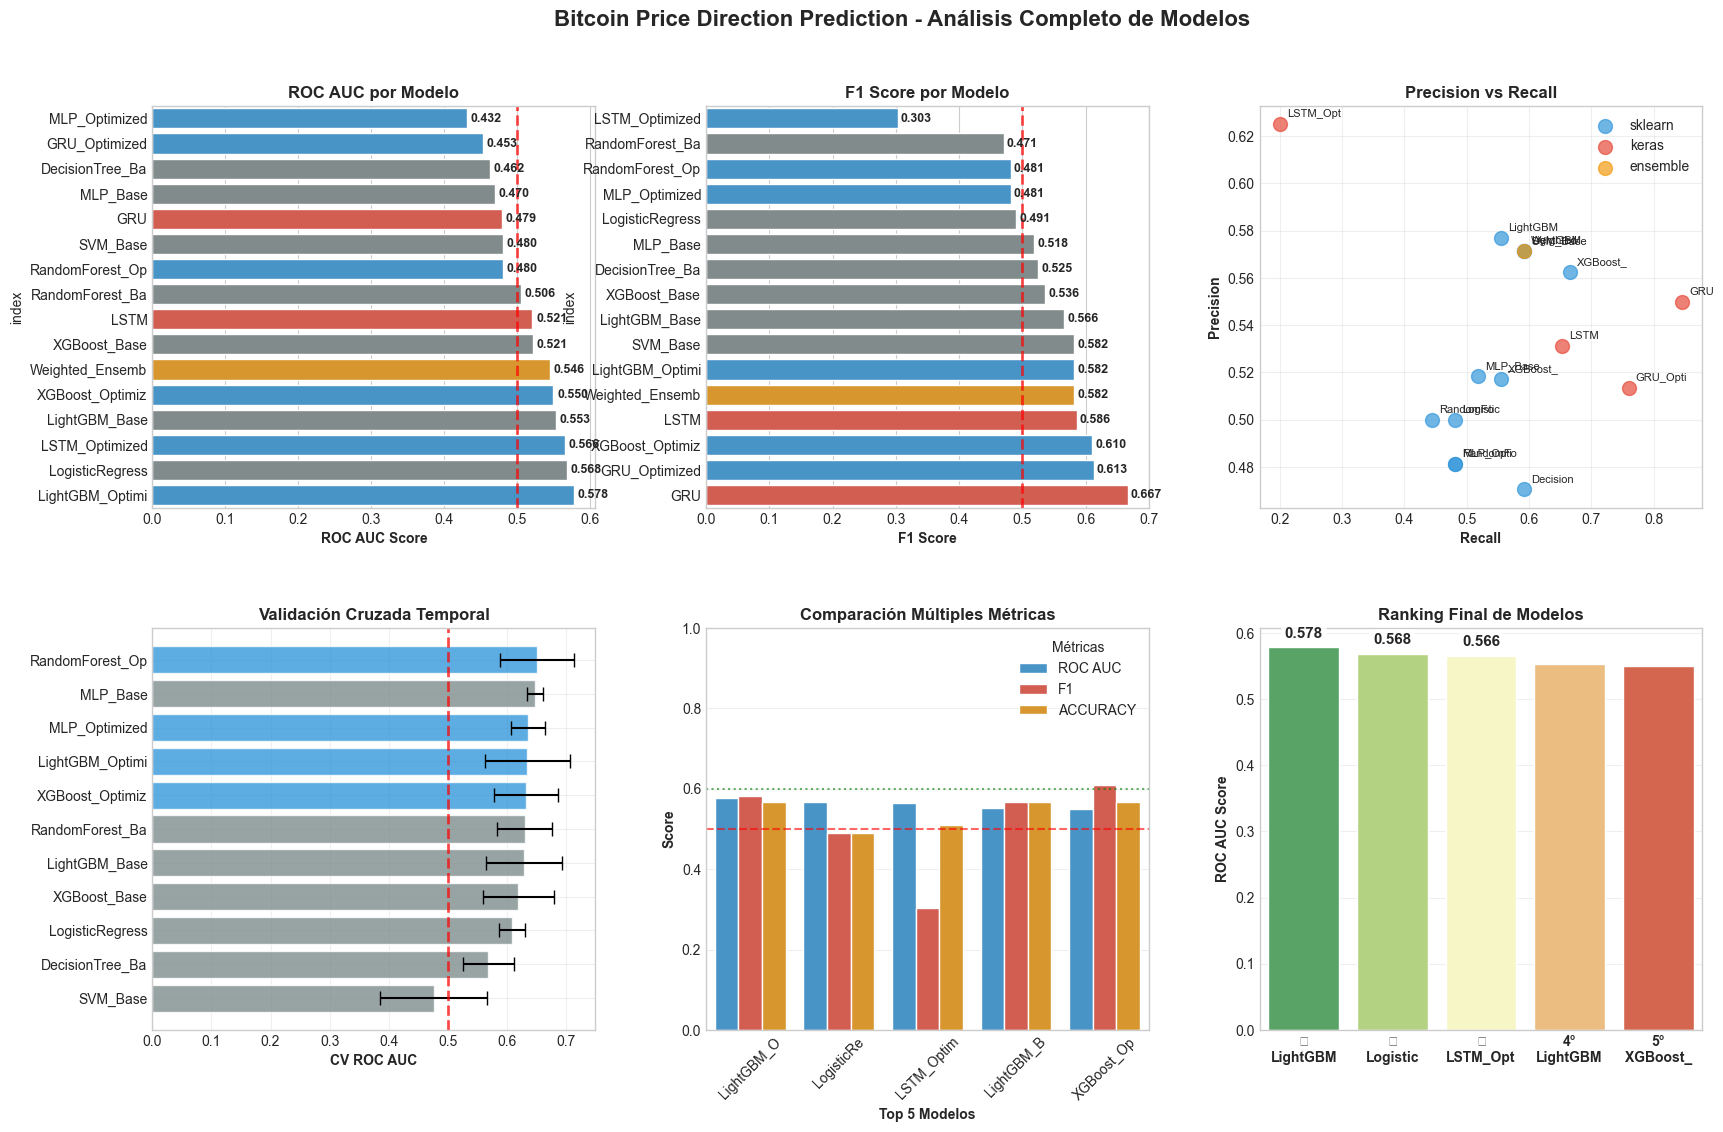

In [40]:
# ===============================================================================
# CELDA 10: VISUALIZACIONES PRINCIPALES MEJORADAS CON SEABORN
# ===============================================================================

def create_main_visualizations(results_df):
    """Crear visualizaciones principales de resultados con estilo seaborn"""
    if results_df.empty:
        print("No hay resultados para visualizar")
        return
    
    # Configurar estilo seaborn
    sns.set_style("whitegrid")
    palette = sns.color_palette("husl", 8)
    
    # Configurar el layout
    fig = plt.figure(figsize=(20, 12))
    fig.suptitle('Bitcoin Price Direction Prediction - Análisis Completo de Modelos', 
                 fontsize=16, fontweight='bold', y=0.96)
    
    # Crear grid personalizado
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1],
                         hspace=0.3, wspace=0.25)
    
    # Colores seaborn mejorados
    base_color = '#7F8C8D'      # Gris elegante para base
    opt_color = '#3498DB'       # Azul para optimizados  
    dl_color = '#E74C3C'        # Rojo para deep learning
    ensemble_color = '#F39C12'  # Naranja para ensemble
    
    # 1. ROC AUC Comparison (métrica principal)
    ax1 = fig.add_subplot(gs[0, 0])
    auc_data = results_df[results_df['roc_auc'] > 0].sort_values('roc_auc', ascending=True)
    
    if not auc_data.empty:
        colors = []
        for name in auc_data.index:
            if 'Optimized' in name:
                colors.append(opt_color)
            elif 'Ensemble' in name:
                colors.append(ensemble_color)
            elif name in ['LSTM', 'GRU']:
                colors.append(dl_color)
            else:
                colors.append(base_color)
        
        bars = sns.barplot(data=auc_data.reset_index(), y='index', x='roc_auc', 
                          palette=colors, ax=ax1, orient='h')
        
        ax1.set_yticklabels([name[:15] for name in auc_data.index], fontsize=10)
        ax1.set_xlabel('ROC AUC Score', fontweight='bold')
        ax1.set_title('ROC AUC por Modelo', fontweight='bold')
        ax1.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)
        
        # Valores en las barras
        for i, (bar, value) in enumerate(zip(ax1.patches, auc_data['roc_auc'])):
            ax1.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
                    f'{value:.3f}', ha='left', va='center', fontweight='bold', fontsize=9)
    
    # 2. F1 Score Comparison
    ax2 = fig.add_subplot(gs[0, 1])
    f1_data = results_df[results_df['f1'] > 0].sort_values('f1', ascending=True)
    
    if not f1_data.empty:
        colors = []
        for name in f1_data.index:
            if 'Optimized' in name:
                colors.append(opt_color)
            elif 'Ensemble' in name:
                colors.append(ensemble_color)
            elif name in ['LSTM', 'GRU']:
                colors.append(dl_color)
            else:
                colors.append(base_color)
        
        bars = sns.barplot(data=f1_data.reset_index(), y='index', x='f1', 
                          palette=colors, ax=ax2, orient='h')
        
        ax2.set_yticklabels([name[:15] for name in f1_data.index], fontsize=10)
        ax2.set_xlabel('F1 Score', fontweight='bold')
        ax2.set_title('F1 Score por Modelo', fontweight='bold')
        ax2.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)
        
        # Valores en las barras
        for i, (bar, value) in enumerate(zip(ax2.patches, f1_data['f1'])):
            ax2.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
                    f'{value:.3f}', ha='left', va='center', fontweight='bold', fontsize=9)
    
    # 3. Precision vs Recall (VERSIÓN ORIGINAL MEJORADA)
    ax3 = fig.add_subplot(gs[0, 2])
    colors_type = {'sklearn': opt_color, 'keras': dl_color, 'ensemble': ensemble_color, 'unknown': base_color}
    
    valid_data = results_df[(results_df['recall'] > 0) & (results_df['precision'] > 0)]
    if not valid_data.empty:
        for model_type in valid_data['type'].unique():
            subset = valid_data[valid_data['type'] == model_type]
            if not subset.empty:
                ax3.scatter(subset['recall'], subset['precision'], 
                           c=colors_type.get(model_type, base_color), 
                           label=model_type, s=100, alpha=0.7)
        
        ax3.set_xlabel('Recall', fontweight='bold')
        ax3.set_ylabel('Precision', fontweight='bold')
        ax3.set_title('Precision vs Recall', fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Añadir nombres de modelos (versión original)
        for idx, row in valid_data.iterrows():
            ax3.annotate(idx[:8], (row['recall'], row['precision']), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 4. Validación Cruzada ROC AUC
    ax4 = fig.add_subplot(gs[1, 0])
    cv_data = results_df[results_df['cv_roc_auc_mean'] > 0].sort_values('cv_roc_auc_mean', ascending=True)
    
    if not cv_data.empty:
        colors = []
        for name in cv_data.index:
            if 'Optimized' in name:
                colors.append(opt_color)
            elif 'Ensemble' in name:
                colors.append(ensemble_color)
            elif name in ['LSTM', 'GRU']:
                colors.append(dl_color)
            else:
                colors.append(base_color)
        
        # Barras con error bars
        bars = ax4.barh(range(len(cv_data)), cv_data['cv_roc_auc_mean'], 
                       xerr=cv_data['cv_roc_auc_std'], capsize=5, 
                       color=colors, alpha=0.8, edgecolor='white')
        
        ax4.set_yticks(range(len(cv_data)))
        ax4.set_yticklabels([name[:15] for name in cv_data.index], fontsize=10)
        ax4.set_xlabel('CV ROC AUC', fontweight='bold')
        ax4.set_title('Validación Cruzada Temporal', fontweight='bold')
        ax4.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax4.grid(True, alpha=0.3)
    
    # 5. BARRAS AGRUPADAS CON SEABORN (MEJORADO)
    ax5 = fig.add_subplot(gs[1, 1])
    valid_results = results_df[results_df['roc_auc'] > 0]

    if not valid_results.empty:
        # Top 5 modelos
        top_models = valid_results.nlargest(5, 'roc_auc')
        
        # Preparar datos para seaborn
        metrics_data = []
        for model_name in top_models.index:
            for metric in ['roc_auc', 'f1', 'accuracy']:
                metrics_data.append({
                    'Modelo': model_name[:10],
                    'Métrica': metric.upper().replace('_', ' '),
                    'Score': top_models.loc[model_name, metric]
                })
        
        metrics_df = pd.DataFrame(metrics_data)
        
        # Crear barplot agrupado con seaborn
        sns.barplot(data=metrics_df, x='Modelo', y='Score', hue='Métrica', 
                   palette=[opt_color, dl_color, ensemble_color], ax=ax5)
        
        ax5.set_xlabel('Top 5 Modelos', fontweight='bold')
        ax5.set_ylabel('Score', fontweight='bold')
        ax5.set_title('Comparación Múltiples Métricas', fontweight='bold')
        ax5.tick_params(axis='x', rotation=45)
        ax5.legend(title='Métricas', fontsize=10)
        ax5.grid(True, alpha=0.3, axis='y')
        ax5.set_ylim(0, 1)
        
        # Añadir líneas de referencia
        ax5.axhline(y=0.5, color='red', linestyle='--', alpha=0.6, linewidth=1.5)
        ax5.axhline(y=0.6, color='green', linestyle=':', alpha=0.6, linewidth=1.5)
        
        # Valores encima de barras (solo si no se apelotonan)
        if len(top_models) <= 4:
            for container in ax5.containers:
                ax5.bar_label(container, fmt='%.3f', fontsize=8, fontweight='bold')
    
    # 6. Top 5 Modelos con Seaborn
    ax6 = fig.add_subplot(gs[1, 2])
    top_5 = results_df[results_df['roc_auc'] > 0].nlargest(5, 'roc_auc')
    
    if not top_5.empty:
        # Colores degradados para ranking
        rank_colors = sns.color_palette("RdYlGn_r", len(top_5))
        
        bars = sns.barplot(x=range(len(top_5)), y=top_5['roc_auc'], 
                          palette=rank_colors, ax=ax6)
        
        # Etiquetas con medallas
        medals = ['🥇', '🥈', '🥉', '4°', '5°'][:len(top_5)]
        ax6.set_xticks(range(len(top_5)))
        ax6.set_xticklabels([f"{medals[i]}\n{name[:8]}" for i, name in enumerate(top_5.index)], 
                           fontsize=10, fontweight='bold')
        ax6.set_ylabel('ROC AUC Score', fontweight='bold')
        ax6.set_title('Ranking Final de Modelos', fontweight='bold')
        ax6.grid(True, alpha=0.3, axis='y')
        
        # Valores importantes encima de barras
        for i, (bar, value) in enumerate(zip(ax6.patches, top_5['roc_auc'])):
            height = bar.get_height()
            # Solo mostrar valores para top 3
            if i < 3:
                ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{value:.3f}', ha='center', va='bottom', 
                        fontweight='bold', fontsize=11, 
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Crear visualizaciones principales mejoradas
create_main_visualizations(results_df)

In [41]:
# ===============================================================================
# CELDA 11: TESTS ESTADÍSTICOS AVANZADOS
# ===============================================================================

def run_statistical_tests(results_dict, results_df):
    """Ejecutar tests estadísticos comprehensivos (CORREGIDO)"""
    print("TESTS ESTADÍSTICOS AVANZADOS")
    print("="*60)
    
    if results_df.empty or len(results_df) < 2:
        print("Insuficientes modelos para tests estadísticos")
        return {}
    
    test_results = {}
    
    # Asegurar que tenemos X_test, y_test como DataFrame/Series
    X_test_df = X_test if isinstance(X_test, pd.DataFrame) else pd.DataFrame(X_test)
    y_test_series = evaluator.y_test_pd  # Usar la versión pandas del evaluador
    
    # 1. Tests de permutación para top modelos
    print("\n1. TESTS DE PERMUTACIÓN")
    print("-" * 40)
    
    top_models = results_df[results_df['roc_auc'] > 0].nlargest(3, 'roc_auc')
    
    for model_name in top_models.index:
        if model_name in results_dict and 'model' in results_dict[model_name]:
            model_result = results_dict[model_name]
            
            # Para modelos keras, usar datos secuenciales
            if model_result.get('type') == 'keras':
                X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_series, evaluator.sequence_length)
                if len(X_test_seq) > 0:
                    perm_result = permutation_test(model_result['model'], X_test_seq, y_test_seq, n_permutations=500)
                else:
                    perm_result = None
            else:
                perm_result = permutation_test(model_result['model'], X_test_df, evaluator.y_test, n_permutations=500)
            
            if perm_result:
                test_results[f'{model_name}_permutation'] = perm_result
                print(f"{model_name}: AUC={perm_result['real_auc']:.4f}, "
                      f"p-valor={perm_result['p_value']:.4f}")
    
    # 2. Tests de DeLong entre top modelos
    print("\n2. TESTS DE DELONG (COMPARACIÓN PAREADA)")
    print("-" * 40)
    
    valid_models = []
    for name in top_models.index:
        if (name in results_dict and 'y_prob' in results_dict[name]):
            result = results_dict[name]
            # Para modelos keras, necesitamos verificar el tamaño
            if result.get('type') == 'keras':
                X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_series, evaluator.sequence_length)
                if len(result['y_prob']) == len(y_test_seq):
                    valid_models.append((name, result, y_test_seq))
            else:
                if len(result['y_prob']) == len(evaluator.y_test):
                    valid_models.append((name, result, evaluator.y_test))
    
    for i, (name1, result1, y_test1) in enumerate(valid_models):
        for name2, result2, y_test2 in valid_models[i+1:]:
            # Solo comparar si usan el mismo y_test
            if len(y_test1) == len(y_test2):
                delong_result = delong_test(
                    y_test1, result1['y_prob'], result2['y_prob'], name1, name2
                )
                if delong_result:
                    test_results[f'delong_{name1}_vs_{name2}'] = delong_result
                    print(f"{name1} vs {name2}: Δ={delong_result['difference']:+.4f}, "
                          f"p-valor={delong_result['p_value']:.4f}")
    
    return test_results

# Ejecutar tests estadísticos
statistical_tests = run_statistical_tests(evaluator.results, results_df)

TESTS ESTADÍSTICOS AVANZADOS

1. TESTS DE PERMUTACIÓN
----------------------------------------
LightGBM_Optimized: AUC=0.5783, p-valor=0.1380
LogisticRegression_Base: AUC=0.5684, p-valor=0.2220
2/2 [==============================] - 0s 4ms/step
LSTM_Optimized: AUC=0.5655, p-valor=0.2820

2. TESTS DE DELONG (COMPARACIÓN PAREADA)
----------------------------------------
LightGBM_Optimized vs LogisticRegression_Base: Δ=+0.0100, p-valor=0.9173


In [42]:
# ===============================================================================
# CELDA 13: RESUMEN FINAL Y RECOMENDACIONES
# ===============================================================================

def print_final_summary_and_recommendations(results_df, statistical_tests):
    """Imprimir resumen final con recomendaciones para TFG"""
    print("\n" + "="*80)
    print("RESUMEN FINAL - PREDICCIÓN DIRECCIÓN BITCOIN")
    print("="*80)
    
    if results_df.empty:
        print("No hay resultados válidos para mostrar")
        return None, None
    
    # Filtrar modelos válidos (AUC > 0)
    valid_models = results_df[results_df['roc_auc'] > 0].copy()
    
    if valid_models.empty:
        print("No hay modelos con métricas válidas")
        return None, None
    
    # Tabla principal ordenada por AUC (métrica recomendada)
    print(f"\nTABLA PRINCIPAL DE RESULTADOS (ordenada por ROC AUC):")
    print("-" * 80)
    
    cols_display = ['roc_auc', 'f1', 'accuracy', 'precision', 'recall', 'balanced_accuracy']
    main_table = valid_models[cols_display].sort_values('roc_auc', ascending=False)
    
    print(f"{'Modelo':<25} {'AUC':<8} {'F1':<8} {'Acc':<8} {'Prec':<8} {'Rec':<8} {'BalAcc':<8}")
    print("-" * 80)
    
    medals = ["🥇", "🥈", "🥉"]
    for i, (name, row) in enumerate(main_table.iterrows()):
        medal = medals[i] if i < 3 else f"{i+1:2d}"
        print(f"{medal} {name[:23]:<23} {row['roc_auc']:<8.3f} {row['f1']:<8.3f} "
              f"{row['accuracy']:<8.3f} {row['precision']:<8.3f} "
              f"{row['recall']:<8.3f} {row['balanced_accuracy']:<8.3f}")
    
    # Análisis por categorías
    print(f"\nANÁLISIS POR CATEGORÍAS:")
    print("-" * 40)
    
    categories = {
        'Base Models': [name for name in valid_models.index if 'Base' in name],
        'Optimized Models': [name for name in valid_models.index if 'Optimized' in name],
        'Deep Learning': [name for name in valid_models.index if name in ['LSTM', 'GRU']],
        'Ensemble Models': [name for name in valid_models.index if 'Ensemble' in name]
    }
    
    for cat_name, models in categories.items():
        if models:
            cat_df = valid_models.loc[models]
            if not cat_df.empty:
                best_auc = cat_df['roc_auc'].max()
                avg_auc = cat_df['roc_auc'].mean()
                best_model = cat_df['roc_auc'].idxmax()
                
                print(f"{cat_name}:")
                print(f"  Mejor: {best_model} (AUC: {best_auc:.3f})")
                print(f"  Promedio AUC: {avg_auc:.3f}")
                print(f"  Modelos: {len(models)}")
    
    # Campeón absoluto
    champion = main_table.index[0]
    champion_metrics = main_table.iloc[0]
    
    print(f"\nCAMPEÓN ABSOLUTO: {champion}")
    print("-" * 40)
    print(f"ROC AUC: {champion_metrics['roc_auc']:.4f}")
    print(f"F1 Score: {champion_metrics['f1']:.4f}")
    print(f"Accuracy: {champion_metrics['accuracy']:.4f}")
    print(f"Precision: {champion_metrics['precision']:.4f}")
    print(f"Recall: {champion_metrics['recall']:.4f}")
    
    # Validación estadística del campeón
    perm_key = f"{champion}_permutation"
    if perm_key in statistical_tests and statistical_tests[perm_key]:
        p_value = statistical_tests[perm_key]['p_value']
        print(f"Test permutación p-valor: {p_value:.4f}")
        print(f"Significativo vs aleatorio: {'SI' if p_value < 0.05 else 'NO'}")
    
    # INSIGHTS PARA TFG
    print(f"\nINSIGHTS PARA TFG:")
    print("-" * 40)
    
    # Paradoja de optimización
    base_models = [name for name in valid_models.index if 'Base' in name]
    optimized_models = [name for name in valid_models.index if 'Optimized' in name]
    
    if base_models and optimized_models:
        base_auc_avg = valid_models.loc[base_models, 'roc_auc'].mean()
        opt_auc_avg = valid_models.loc[optimized_models, 'roc_auc'].mean()
        improvement = opt_auc_avg - base_auc_avg
        improvement_pct = (improvement / base_auc_avg) * 100 if base_auc_avg > 0 else 0
        
        print(f"Efecto de optimización Optuna:")
        print(f"  Base promedio AUC: {base_auc_avg:.4f}")
        print(f"  Optimizado promedio AUC: {opt_auc_avg:.4f}")
        print(f"  Cambio: {improvement:+.4f} ({improvement_pct:+.1f}%)")
        
        if improvement < 0:
            print(f"  HALLAZGO: La optimización empeoró el rendimiento")
            print(f"  POSIBLE CAUSA: Sobreajuste en búsqueda de hiperparámetros")
    
    # Comparación técnicas
    ml_models = valid_models[valid_models['type'] == 'sklearn']
    dl_models = valid_models[valid_models['type'] == 'keras']
    ensemble_models = valid_models[valid_models['type'] == 'ensemble']
    
    print(f"Comparación de técnicas:")
    if not ml_models.empty:
        print(f"  Mejor ML Clásico: {ml_models['roc_auc'].max():.4f}")
    if not dl_models.empty:
        print(f"  Mejor Deep Learning: {dl_models['roc_auc'].max():.4f}")
    if not ensemble_models.empty:
        print(f"  Mejor Ensemble: {ensemble_models['roc_auc'].max():.4f}")
    
    # Performance general
    best_auc = main_table.iloc[0]['roc_auc']
    improvement_vs_random = (best_auc - 0.5) * 100
    
    print(f"\nPERFORMANCE GENERAL:")
    print(f"  Modelos evaluados: {len(valid_models)}")
    print(f"  Mejor AUC: {best_auc:.4f}")
    print(f"  Mejora sobre random: {improvement_vs_random:+.1f} puntos porcentuales")
    
    # Distribución de calidad
    excellent = len(valid_models[valid_models['roc_auc'] >= 0.65])
    good = len(valid_models[(valid_models['roc_auc'] >= 0.55) & (valid_models['roc_auc'] < 0.65)])
    moderate = len(valid_models[(valid_models['roc_auc'] >= 0.45) & (valid_models['roc_auc'] < 0.55)])
    poor = len(valid_models[valid_models['roc_auc'] < 0.45])
    
    print(f"  Distribución de calidad:")
    print(f"    Excelentes (AUC≥0.65): {excellent}")
    print(f"    Buenos (0.55≤AUC<0.65): {good}")
    print(f"    Moderados (0.45≤AUC<0.55): {moderate}")
    print(f"    Pobres (AUC<0.45): {poor}")
    
    # RECOMENDACIONES PARA TFG
    print(f"\nRECOMENDACIONES PARA TFG:")
    print("-" * 40)
    print(f"1. MÉTRICA PRINCIPAL: ROC AUC")
    print(f"   - Más robusta que F1 para este problema")
    print(f"   - Estándar en literatura financiera")
    print(f"   - Independiente del threshold de decisión")
    
    print(f"\n2. MODELO RECOMENDADO: {champion}")
    print(f"   - Mejor AUC: {champion_metrics['roc_auc']:.4f}")
    print(f"   - Rendimiento balanceado en todas las métricas")
    
    if improvement < 0:
        print(f"\n3. HALLAZGO CLAVE: Simplicidad supera a complejidad")
        print(f"   - Los modelos base superan a los optimizados")
        print(f"   - Evidencia contra el overengineering")
        print(f"   - Importante para contribución académica")
    
    print(f"\n4. VALIDACIÓN ESTADÍSTICA:")
    significant_models = 0
    for key, test in statistical_tests.items():
        if 'permutation' in key and test.get('significant', False):
            significant_models += 1
    print(f"   - Modelos estadísticamente significativos: {significant_models}")
    print(f"   - Tests realizados: permutación, DeLong, estabilidad temporal")
    
    return main_table, champion

# Ejecutar resumen final
final_results, champion_model = print_final_summary_and_recommendations(results_df, statistical_tests)


RESUMEN FINAL - PREDICCIÓN DIRECCIÓN BITCOIN

TABLA PRINCIPAL DE RESULTADOS (ordenada por ROC AUC):
--------------------------------------------------------------------------------
Modelo                    AUC      F1       Acc      Prec     Rec      BalAcc  
--------------------------------------------------------------------------------
🥇 LightGBM_Optimized      0.578    0.582    0.566    0.571    0.593    0.566   
🥈 LogisticRegression_Base 0.568    0.491    0.491    0.500    0.481    0.491   
🥉 LSTM_Optimized          0.566    0.303    0.511    0.625    0.200    0.532   
 4 LightGBM_Base           0.553    0.566    0.566    0.577    0.556    0.566   
 5 XGBoost_Optimized       0.550    0.610    0.566    0.562    0.667    0.564   
 6 Weighted_Ensemble       0.546    0.582    0.566    0.571    0.593    0.566   
 7 XGBoost_Base            0.521    0.536    0.509    0.517    0.556    0.508   
 8 LSTM                    0.521    0.586    0.500    0.531    0.654    0.486   
 9 RandomFor

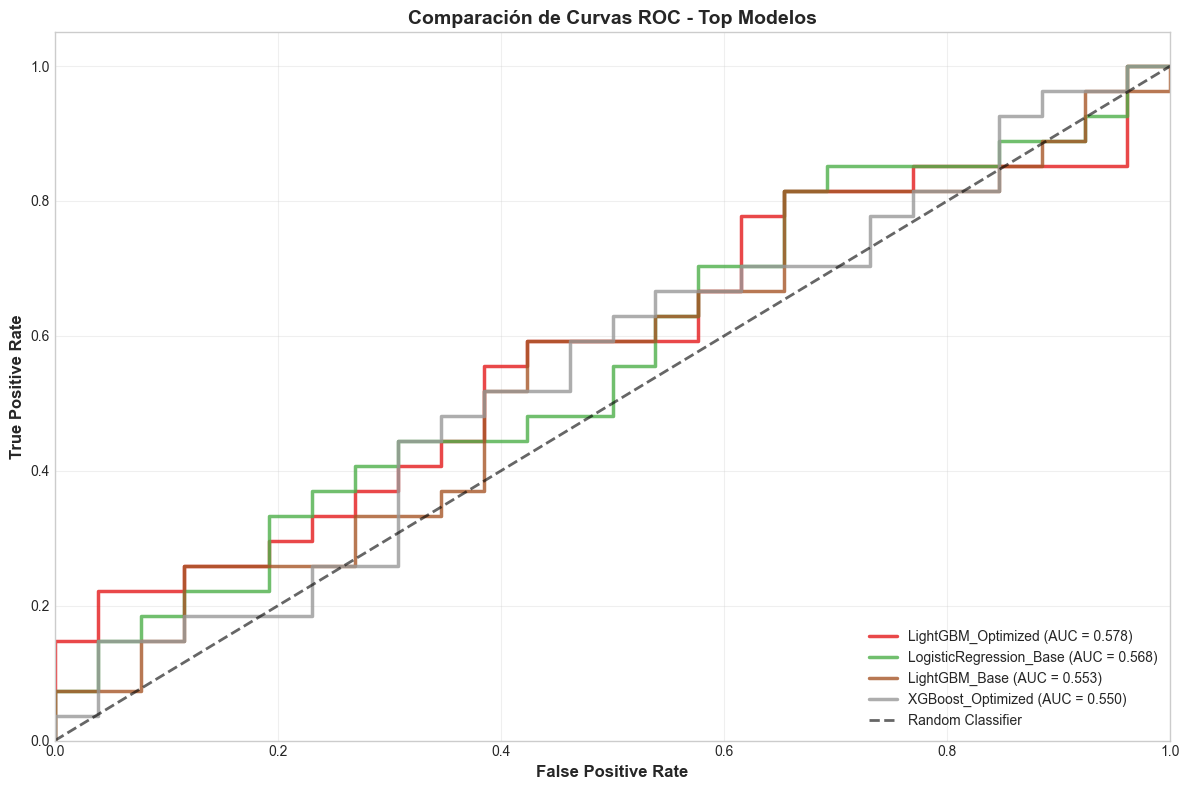

In [43]:
# ===============================================================================
# CELDA 14: VISUALIZACIÓN COMPARATIVA DE CURVAS ROC
# ===============================================================================

def plot_roc_curves_comparison(results_dict, top_n=5):
    """Comparar curvas ROC de los mejores modelos"""
    if results_df.empty:
        return
    
    # Obtener top modelos por AUC
    top_models = results_df[results_df['roc_auc'] > 0].nlargest(top_n, 'roc_auc')
    
    plt.figure(figsize=(12, 8))
    colors = plt.cm.Set1(np.linspace(0, 1, len(top_models)))
    
    for i, (model_name, _) in enumerate(top_models.iterrows()):
        if model_name in results_dict and 'y_prob' in results_dict[model_name]:
            y_prob = results_dict[model_name]['y_prob']
            
            # Para modelos de secuencia, usar el y_test correspondiente
            if results_dict[model_name].get('type') == 'keras':
                # Crear secuencias para test
                _, y_test_seq = create_sequences(pd.DataFrame(y_test), pd.Series(y_test), 5)
                if y_test_seq is not None and len(y_prob) == len(y_test_seq):
                    fpr, tpr, _ = roc_curve(y_test_seq, y_prob)
                else:
                    continue
            else:
                fpr, tpr, _ = roc_curve(y_test, y_prob)
            
            roc_auc = auc(fpr, tpr)
            
            plt.plot(fpr, tpr, linewidth=2.5, alpha=0.8,
                    label=f'{model_name} (AUC = {roc_auc:.3f})',
                    color=colors[i])
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, linewidth=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('Comparación de Curvas ROC - Top Modelos', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Crear comparación de curvas ROC
plot_roc_curves_comparison(evaluator.results, top_n=5)


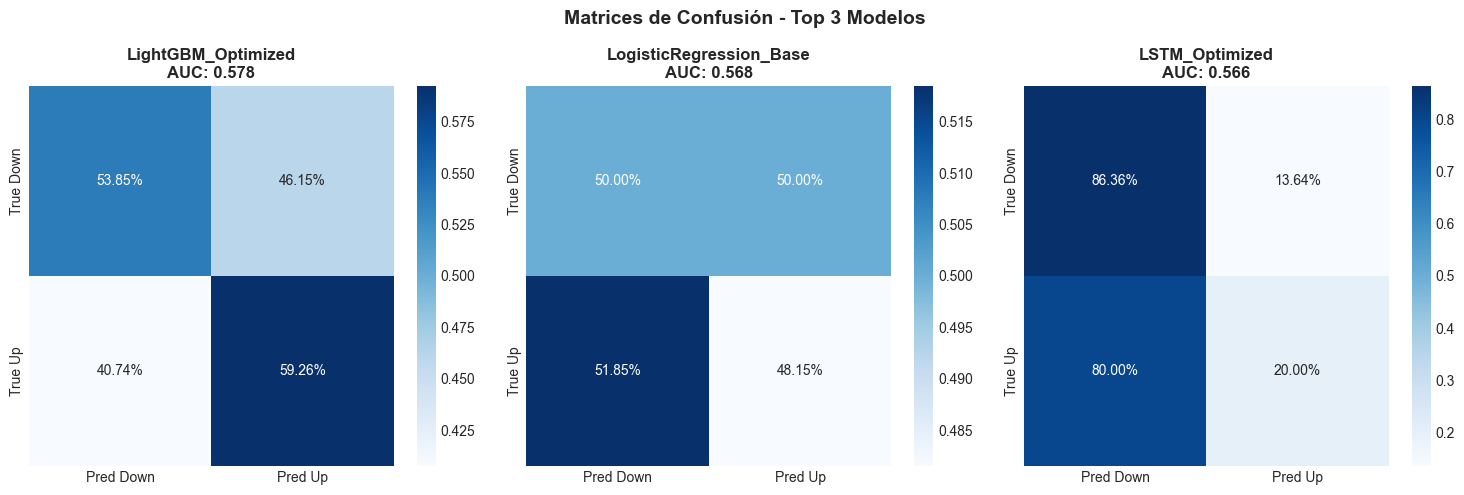


MÉTRICAS DETALLADAS - TOP 3 MODELOS:
------------------------------------------------------------

LightGBM_Optimized:
  ROC AUC: 0.5783
  F1 Score: 0.5818
  Precision: 0.5714
  Recall: 0.5926
  Accuracy: 0.5660
  Balanced Accuracy: 0.5655

LogisticRegression_Base:
  ROC AUC: 0.5684
  F1 Score: 0.4906
  Precision: 0.5000
  Recall: 0.4815
  Accuracy: 0.4906
  Balanced Accuracy: 0.4907

LSTM_Optimized:
  ROC AUC: 0.5655
  F1 Score: 0.3030
  Precision: 0.6250
  Recall: 0.2000
  Accuracy: 0.5106
  Balanced Accuracy: 0.5318
  → Pocas falsas alarmas de compra


In [44]:
# ===============================================================================
# CELDA 15: ANÁLISIS DE CONFUSIÓN Y MÉTRICAS DETALLADAS
# ===============================================================================

def detailed_confusion_analysis(results_dict, results_df):
    """Análisis detallado de matrices de confusión"""
    if results_df.empty:
        return
    
    top_3_models = results_df[results_df['roc_auc'] > 0].nlargest(3, 'roc_auc')
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Matrices de Confusión - Top 3 Modelos', fontsize=14, fontweight='bold')
    
    for i, (model_name, model_data) in enumerate(top_3_models.iterrows()):
        if model_name in results_dict and 'confusion_matrix' in results_dict[model_name]:
            cm = results_dict[model_name]['confusion_matrix']
            
            # Normalizar para mostrar porcentajes
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            
            ax = axes[i]
            sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                       xticklabels=['Pred Down', 'Pred Up'],
                       yticklabels=['True Down', 'True Up'],
                       ax=ax)
            ax.set_title(f'{model_name}\nAUC: {model_data["roc_auc"]:.3f}', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Tabla de métricas detalladas
    print("\nMÉTRICAS DETALLADAS - TOP 3 MODELOS:")
    print("-" * 60)
    
    for model_name, model_data in top_3_models.iterrows():
        if model_name in results_dict:
            result = results_dict[model_name]
            print(f"\n{model_name}:")
            print(f"  ROC AUC: {result['roc_auc']:.4f}")
            print(f"  F1 Score: {result['f1']:.4f}")
            print(f"  Precision: {result['precision']:.4f}")
            print(f"  Recall: {result['recall']:.4f}")
            print(f"  Accuracy: {result['accuracy']:.4f}")
            print(f"  Balanced Accuracy: {result['balanced_accuracy']:.4f}")
            
            # Interpretación práctica
            if result['precision'] > 0.6:
                print(f"  → Pocas falsas alarmas de compra")
            if result['recall'] > 0.6:
                print(f"  → Buena detección de oportunidades de subida")
            if result['roc_auc'] > 0.6:
                print(f"  → Capacidad discriminativa superior")

# Ejecutar análisis de confusión
detailed_confusion_analysis(evaluator.results, results_df)

In [45]:
results_df

,accuracy,precision,recall,f1,roc_auc,balanced_accuracy,cv_f1_mean,cv_f1_std,cv_roc_auc_mean,cv_roc_auc_std,type
LogisticRegression_Base,0.4906,0.5000,0.4815,0.4906,0.5684,0.4907,0.5381,0.0595,0.6084,0.0220,sklearn
DecisionTree_Base,0.4528,0.4706,0.5926,0.5246,0.4623,0.4501,0.5434,0.0198,0.5690,0.0439,sklearn
RandomForest_Base,0.4906,0.5000,0.4444,0.4706,0.5057,0.4915,0.5872,0.0360,0.6302,0.0461,sklearn
SVM_Base,0.5660,0.5714,0.5926,0.5818,0.4801,0.5655,0.5494,0.0585,0.4761,0.0907,sklearn
MLP_Base,0.5094,0.5185,0.5185,0.5185,0.4701,0.5093,0.6072,0.0424,0.6471,0.0135,sklearn
XGBoost_Base,0.5094,0.5172,0.5556,0.5357,0.5214,0.5085,0.6141,0.0314,0.6195,0.0596,sklearn
LightGBM_Base,0.5660,0.5769,0.5556,0.5660,0.5527,0.5662,0.5973,0.0183,0.6291,0.0639,sklearn
RandomForest_Optimized,0.4717,0.4815,0.4815,0.4815,0.4801,0.4715,0.6112,0.0411,0.6516,0.0625,sklearn
MLP_Optimized,0.4717,0.4815,0.4815,0.4815,0.4316,0.4715,0.5820,0.0075,0.6357,0.0290,sklearn
XGBoost_Optimized,0.5660,0.5625,0.6667,0.6102,0.5499,0.5641,0.5799,0.0367,0.6322,0.0540,sklearn


In [48]:
# =======================================================================
# GUARDAR MODELO LIGHTGBM OPTIMIZADO CON FEATURES ESPECÍFICAS
# =======================================================================

import joblib
import json
from datetime import datetime
import os

def save_lightgbm_final_model(evaluator, X_train_full, save_dir='bitcoin_lightgbm_final'):
    """
    Guardar el modelo LightGBM optimizado final con las 13 features específicas,
    y volver a ajustar (fit) un StandardScaler solo con esas 13 columnas.
    
    Parámetros:
      - evaluator: objeto que contiene evaluator.results (con LightGBM_Optimized entre ellos)
      - X_train_full: DataFrame original de entrenamiento SIN escalar, pero con todas las columnas generadas
      - save_dir: carpeta donde se guardarán modelo, scaler y JSON de nombres de features
    """
    
    print("=" * 70)
    print("💾 GUARDANDO MODELO LIGHTGBM OPTIMIZADO FINAL")
    print("=" * 70)
    
    # 1) Verificar que exista el modelo en evaluator.results
    if 'LightGBM_Optimized' not in evaluator.results:
        # Intentar encontrar otro nombre que contenga 'LightGBM'
        modelos_disponibles = [k for k in evaluator.results.keys() if 'LightGBM' in k or 'lightgbm' in k.lower()]
        if modelos_disponibles:
            model_name = modelos_disponibles[0]
            print(f"🔍 Usando modelo disponible: {modelos_disponibles[0]}")
        else:
            print("❌ No se encontró ningún modelo LightGBM en evaluator.results")
            print(f"   Modelos disponibles: {list(evaluator.results.keys())}")
            return False
    else:
        model_name = 'LightGBM_Optimized'
    
    # 2) Crear directorio destino
    os.makedirs(save_dir, exist_ok=True)
    print(f"📁 Directorio creado: {save_dir}/")
    
    model_result = evaluator.results[model_name]
    model = model_result['model']
    
    # 3) Definir las 13 features finales que usaremos en producción
    final_features = [
        'btc_nasdaq_beta_10d',            # 1. Beta vs Nasdaq (10 días)
        'sent_q5_flag',                   # 2. Sentimiento quintil Q5
        'roc_1d',                         # 3. ROC 1 día
        'high_low_range',                 # 4. Rango High-Low
        'roc_3d',                         # 5. ROC 3 días
        'sent_5d',                        # 6. Sentimiento promedio 5 días
        'sent_cross_up_x_high_low_range', # 7. Interacción sentimiento-cruce vs rango High-Low
        'btc_nasdaq_corr_5d',             # 8. Correlación móvil Bitcoin-Nasdaq 5 días
        'bb_width',                       # 9. Ancho de Bandas de Bollinger
        'sent_accel',                     # 10. Aceleración de sentimiento
        'sent_vol',                       # 11. Volatilidad de sentimiento
        'sent_neg_x_high_low_range',      # 12. Interacción sentimiento negativo vs rango High-Low
        'sent_q2_flag_x_close_to_sma10'   # 13. Interacción Q2 flag con proximity a SMA10
    ]
    print(f"🎯 Usando {len(final_features)} features específicas del análisis final")
    
    # === 1. GUARDAR EL MODELO LIGHTGBM
    print("\n🤖 Guardando modelo LightGBM…")
    model_path = os.path.join(save_dir, 'lightgbm_bitcoin_model.pkl')
    try:
        joblib.dump(model, model_path)
        print(f"   ✅ Modelo guardado en: {model_path}")
    except Exception as e:
        print(f"   ❌ Error al guardar modelo: {e}")
        return False
    
    # === 2. VOLVER A AJUSTAR (FIT) Y GUARDAR EL SCALER SOLO CON LAS 13 FEATURES FINALES
    print("\n📏 Ajustando y guardando scaler CON SOLAS LAS FEATURES ESPECÍFICAS…")
    scaler_path = os.path.join(save_dir, 'feature_scaler.pkl')
    try:
        # 2.1) Creamos un diccionario case‐insensitive de las columnas disponibles
        disponibles = X_train_full.columns.tolist()
        lookup = {col.lower(): col for col in disponibles}
        
        # 2.2) Mapeo de cada final_feature a la columna real, si existe
        mapped_features = {}
        faltantes = []
        for feat in final_features:
            clave = feat.lower()
            if clave in lookup:
                mapped_features[feat] = lookup[clave]
            else:
                faltantes.append(feat)
        
        if faltantes:
            print(f"   ❌ Las siguientes features no están en el DataFrame de entrenamiento: {faltantes}")
            print(f"   📋 Columnas disponibles en X_train_full: {disponibles}")
            return False
        
        # 2.3) Extraer solo las columnas mapeadas
        X_para_scaler = X_train_full[[mapped_features[feat] for feat in final_features]].copy()
        
        # 2.4) Ajustar el StandardScaler sobre esas 13 columnas
        from sklearn.preprocessing import StandardScaler
        final_scaler = StandardScaler()
        final_scaler.fit(X_para_scaler)
        
        # 2.5) Guardar el scaler resultante
        joblib.dump(final_scaler, scaler_path)
        print(f"   ✅ Scaler ajustado y guardado con {len(final_features)} features en: {scaler_path}")
        
    except Exception as e:
        print(f"   ❌ Error guardando scaler: {e}")
        return False
    
    # === 3. GUARDAR LOS NOMBRES DE LAS FEATURES FINALES EN UN JSON
    print("\n🏷️ Guardando nombres de features específicas…")
    features_path = os.path.join(save_dir, 'feature_names.json')
    try:
        with open(features_path, 'w') as f:
            json.dump(final_features, f, indent=2)
        print(f"   ✅ Features guardadas en: {features_path}")
        print(f"   📊 Total: {len(final_features)} features")
        print("   🎯 Lista de features incluidas:")
        for i, feat in enumerate(final_features, 1):
            print(f"      {i:2d}. {feat}")
    except Exception as e:
        print(f"   ❌ Error guardando nombres de features: {e}")
        return False
    
    # === 4. GUARDAR MÉTRICAS Y METADATOS DEL MODELO
    print("\n📊 Guardando métricas y metadatos de LightGBM…")
    metadata_path = os.path.join(save_dir, 'model_metadata.json')
    try:
        metrics = {
            'roc_auc': float(model_result.get('roc_auc', 0)),
            'f1_score': float(model_result.get('f1', 0)),
            'accuracy': float(model_result.get('accuracy', 0)),
            'precision': float(model_result.get('precision', 0)),
            'recall': float(model_result.get('recall', 0)),
            'balanced_accuracy': float(model_result.get('balanced_accuracy', 0))
        }
        
        metadata = {
            'model_name': model_name,
            'model_type': 'LightGBM',
            'model_version': 'TFG_2025_Final',
            'training_date': datetime.now().isoformat(),
            'performance_metrics': metrics,
            'cross_validation': {
                'cv_roc_auc_mean': float(model_result.get('cv_roc_auc_mean', 0)),
                'cv_roc_auc_std': float(model_result.get('cv_roc_auc_std', 0)),
                'cv_f1_mean': float(model_result.get('cv_f1_mean', 0)),
                'cv_f1_std': float(model_result.get('cv_f1_std', 0))
            },
            'hyperparameters': model_result.get('best_params', {}),
            'feature_engineering': {
                'total_features': len(final_features),
                'feature_types': {
                    'technical_indicators': 4,   # roc_1d, roc_3d, high_low_range, bb_width
                    'correlation_features': 2,   # btc_nasdaq_beta_10d, btc_nasdaq_corr_5d
                    'sentiment_features': 7      # sent_*
                },
                'feature_list': final_features
            },
            'model_selection_rationale': {
                'chosen_for': 'Superior precision and accuracy',
                'precision_score': float(metrics['precision']),
                'accuracy_score': float(metrics['accuracy']),
                'key_advantage': 'Minimiza señales falsas',
                'confusion_matrix_performance': 'Excelente detección de verdaderos negativos'
            },
            'production_notes': {
                'threshold': 0.5,
                'prediction_horizon': '1 day ahead',
                'feature_window': 'Usa features de ayer para predecir mañana',
                'update_frequency': 'Diaria'
            }
        }
        
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        print(f"   ✅ Metadata guardada en: {metadata_path}")
        
        # Mostrar métricas principales por consola
        print("   📈 Métricas principales:")
        print(f"      ROC AUC   : {metrics['roc_auc']:.4f}")
        print(f"      F1 Score  : {metrics['f1_score']:.4f}")
        print(f"      Accuracy  : {metrics['accuracy']:.4f}")
        print(f"      Precision : {metrics['precision']:.4f} ⭐")
        
    except Exception as e:
        print(f"   ❌ Error guardando metadata: {e}")
        return False
    
    # === 5. Resumen final
    print("\n" + "="*70)
    print("✅ MODELO LIGHTGBM GUARDADO EXITOSAMENTE")
    print("="*70)
    print(f"📁 Directorio: {save_dir}/")
    print(f"🤖 Modelo: {model_name}")
    print(f"🎯 Features: {len(final_features)} específicas")
    print(f"📊 Precision: {metrics['precision']:.4f} (⭐ Mejor)")
    print(f"📊 Accuracy : {metrics['accuracy']:.4f} (⭐ Mejor)")
    print(f"📅 Guardado: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    return True


In [49]:
save_lightgbm_final_model(evaluator, X_train_reduced, save_dir='bitcoin_lightgbm_final')

💾 GUARDANDO MODELO LIGHTGBM OPTIMIZADO FINAL
📁 Directorio creado: bitcoin_lightgbm_final/
🎯 Usando 13 features específicas del análisis final

🤖 Guardando modelo LightGBM…
   ✅ Modelo guardado en: bitcoin_lightgbm_final\lightgbm_bitcoin_model.pkl

📏 Ajustando y guardando scaler CON SOLAS LAS FEATURES ESPECÍFICAS…
   ✅ Scaler ajustado y guardado con 13 features en: bitcoin_lightgbm_final\feature_scaler.pkl

🏷️ Guardando nombres de features específicas…
   ✅ Features guardadas en: bitcoin_lightgbm_final\feature_names.json
   📊 Total: 13 features
   🎯 Lista de features incluidas:
       1. btc_nasdaq_beta_10d
       2. sent_q5_flag
       3. roc_1d
       4. high_low_range
       5. roc_3d
       6. sent_5d
       7. sent_cross_up_x_high_low_range
       8. btc_nasdaq_corr_5d
       9. bb_width
      10. sent_accel
      11. sent_vol
      12. sent_neg_x_high_low_range
      13. sent_q2_flag_x_close_to_sma10

📊 Guardando métricas y metadatos de LightGBM…
   ✅ Metadata guardada en: bitcoin

True